# Genomics Assignment 3
Ralph Estanboulieh

### Importing relevant packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.dpi'] = 300            # for high quality figures
plt.rcParams["font.family"] = "Helvetica"
from scipy.stats import gaussian_kde        # for the KDE plots
from matplotlib import cm                   # for fancy colormaps
import re


## Figure 1

In [1064]:
# reading the tables in Pandas dataframes
table1 = pd.read_csv("table1.csv")
table2 = pd.read_csv("table2.csv")
table3 = pd.read_csv("table3.csv")

# turn the percentages into floats
table1["male_percentage"] = [float(x[:-1]) for x in table1["male_percentage"].tolist()]

# get the curated subtypes
subtypes = ["pan_cancer"] + table1["curated_subtype"].tolist()
N_subtypes = len(subtypes)

#### Fixing Table 2
The ICD descriptions do not always match the metastasis count columns. We will have to fix that. 

**NOTE:** It seems like the fix makes it even more different than the original figure. Do NOT run this code unless you have to. 

In [978]:
met_sites = table3.iloc[:, 0].tolist()
icd_codes = [re.findall(r"\'([^\\']*)\'", x) for x in table3.iloc[:, 1]]
icd_codes_to_met_sites = {code:site for codes, site in zip(icd_codes, met_sites) for code in codes}

# had to do the matching manually because the names are not always consistent

met_site_to_met_count = {'ADRENAL_GLAND': 'met_count:Adrenal.Gland',
 'BILIARY_TRACT': 'met_count:Biliary.tract',
 'BLADDER_OR_URINARY_TRACT': 'met_count:Bladder/UT',
 'BONE': 'met_count:Bone',
 'BOWEL': 'met_count:Bowel',
 'BREAST': 'met_count:Breast',
 'CNS_BRAIN': 'met_count:CNS/Brain',
 'GENITAL_FEMALE': 'met_count:Female.Genital',
 'GENITAL_MALE': 'met_count:Male.Genital',
 'HEAD_AND_NECK': 'met_count:Head.and.Neck',
 'KIDNEY': 'met_count:Kidney',
 'LIVER': 'met_count:Liver',
 'LUNG': 'met_count:Lung',
 'LYMPH': 'met_count:Distant.LN',
 'MEDIASTINUM': 'met_count:Mediastinum',
 'OTHER': 'met_count:Unspecified',
 'OVARY': 'met_count:Ovary',
 'PERIPHERAL_NERVOUS_SYSTEM': 'met_count:PNS',
 'PERITONEUM': 'met_count:Intra-Abdominal',
 'PLEURA': 'met_count:Pleura',
 'SKIN': 'met_count:Skin'}

icd_codes_to_met_count = {code:met_site_to_met_count[met_site] for code, met_site in icd_codes_to_met_sites.items()}

# set the met_count:X values to 0

table2.loc[:, table2.columns.str.contains("met_count:")] = 0

for index, row in table2.iterrows():
    row_icd_desc = row["icd_description"]
    if not pd.isna(row_icd_desc):
        row_codes = re.findall(r".{3}\.\d\d?", row_icd_desc)
        row_met_counts = [icd_codes_to_met_count.get(c, "met_count:Unspecified") for c in row_codes]
        for met_count in row_met_counts:
            table2.loc[index, met_count] = table2.loc[index, met_count] + 1

### Age, OS, sex, sample type, and metastasis burden

In [1065]:
def text_plot(subtype, axis):
    tumor_type = "Pan-cancer" if subtype == "pan_cancer" else table1[table1["curated_subtype"]==subtype]["curated_subtype_display"].item()
    abbrev = "PanCan" if subtype == "pan_cancer" else table1[table1["curated_subtype"]==subtype]["curated_subtype_abbr"].item()
    n = str(len(table2)) if subtype == "pan_cancer" else str(len(table2[table2["curated_subtype"]==subtype]))
    
    color = "black" if subtype == "pan_cancer" else table1[table1["curated_subtype"]==subtype]["color_subtype"].item()
    
    axis.text(1, 0, tumor_type, horizontalalignment = 'right', color = color)
    axis.text(2.25, 0, abbrev, horizontalalignment = 'right', color = color)
    axis.text(3, 0, n, horizontalalignment = 'right', color = color)
    
    axis.set_xlim([0,3])
    axis.axis('off')


def age_plot(subtype, axis):
    table = table2 if subtype == "pan_cancer" else table2[table2["curated_subtype"] == subtype]
    
    data = table["seq_report_age"].to_numpy()
    data = data[~np.isnan(data)]/365
    dens = gaussian_kde(data)
    median = np.median(data)
    
    x = np.arange(18, 90, 1)
    axis.plot([median, median], [0, dens(median)[0]], linewidth = 0.5, color = "red")
    axis.plot(x, dens(x), color = "k", linewidth = 0.5)
    axis.axis('off')
    
def kaplan_meier_survival(data):
    x_range = [0] + sorted(list(set(data[data < 5]))) + [5]
    Di = np.histogram(data, x_range)[0]
    Ni = np.array([(data >= x).sum() for x in x_range])
    S = [1 - Di[0]/Ni[0]]
    [S.append(S[-1] * (1 - Di[idx]/Ni[idx])) for idx, x in enumerate(x_range[1:])]
    S = np.array(S)
    median = x_range[np.argmax(S<=0.5)]
    return x_range, S, median
    
def os_plot(subtype, axis):
    table = table2 if subtype == "pan_cancer" else table2[table2["curated_subtype"] == subtype]
    
    data = table["os_days"].to_numpy()
    data = (data + 1)/365
    data[np.isnan(data)] = 100
    xsurv, ysurv, median = kaplan_meier_survival(data)
    median = np.median(data)
    
    axis.plot([median, median], [0, 0.5], linewidth = 1, color = "red")
    axis.plot(xsurv, ysurv, color = "k", linewidth = 0.5)
    axis.set_ylim([0, 1])
    axis.axis('off')
    
def sex_plot(subtype, axis):
    table = table2 if subtype == "pan_cancer" else table2[table2["curated_subtype"] == subtype]
    
    male_perc = (table["sex"] == "Male").sum()/len(table) * 100
    fem_perc = 100 - male_perc
    
    axis.barh([0], [fem_perc], color = "khaki")
    axis.barh([0], [male_perc], left = [fem_perc], color = "slategray")
    axis.set_xlim([0,100])
    axis.axis('off')
    
def sample_type(subtype, axis):
    table = table2 if subtype == "pan_cancer" else table2[table2["curated_subtype"] == subtype]
    
    met = len(table[table["sample_type"] == "Metastasis"])
    primary = len(table[table["met_count"] == 0])
    primary_met = len(table) - primary - met
    
    axis.barh(0, primary, left = 0, color = "skyblue")
    axis.barh(0, primary_met, left = primary, color = "tab:blue")
    axis.barh(0, met, left = primary + primary_met, color = "tab:red")
    axis.axis('off')
    
def metastasis_burden(subtype, axis):
    table = table2 if subtype == "pan_cancer" else table2[table2["curated_subtype"] == subtype]
    
    met_burden = np.array(table["met_count"])
    met_burden = np.histogram(met_burden, [0,1,2,3,4,5,6,np.inf])[0]
    met_burden = met_burden/sum(met_burden)
    starts = np.insert(np.cumsum(met_burden), 0, 0)
    
    cmap = cm.get_cmap('Reds', 8)
    for idx, (burden, start) in enumerate(zip(met_burden, starts)):
        axis.barh(0, burden, left = start, color = cmap(idx+1))
    axis.set_xlim([0, 1])
    axis.axis('off')
    

## Metastasis site heatmap and stacked bar plots

In [1066]:
met_count_cols = table2.columns[table2.columns.str.contains("met_count:")].to_list()

met_count_table = table2.filter(like = "met_count:").copy().ge(1).astype(int)
met_count_table["n_samples"] = 1
met_count_table["curated_subtype"] = table2["curated_subtype"]
met_count_table = met_count_table.groupby("curated_subtype").aggregate(func = np.sum)

pan_cancer_met_count = met_count_table.sum(0)
pan_cancer_met_count.name = "pan_cancer"
met_count_table = met_count_table.append(pan_cancer_met_count)

met_count_table = met_count_table.loc[subtypes,:]

def met_site_heatmap_plot(axis):
    data = met_count_table.to_numpy()
    data = (data / data[:, -1:] * 100).astype('int32')
    sns.heatmap(data[:, 1:-1], cbar = False, 
                annot = True, cmap = "magma_r", 
                linewidths = 1.5, annot_kws = {"fontsize":8}, ax = axis)
    axis.axis('off');
    
def unspec_met_heatmap_plot(axis):
    data = met_count_table.to_numpy()
    data = (data / data[:, -1:] * 100).astype('int32')
    sns.heatmap(data[:, 0:1], cbar = False, 
                annot = True, cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), 
                linewidths = 1.5, annot_kws = {"fontsize":8}, ax = axis)
    axis.axis('off');

met_site_colors = ["#999966", "#c82ffe", 
 "#6228cb", "#5b384f", "#00fe99", 
 "#066633", "#996534", "#679701", 
 "#ca0001", "#35cbfe", "#39699a", 
 "#663367", "#fd6566", "#993332", 
 "#993332", "#fdcc03", "#660001", 
 "#96cc34", "#0e9247", "#e6308e"]

def met_site_bar_plot(subtype, axis):
    counts = met_count_table.loc[subtype, met_count_cols[1:]].to_numpy()
    counts = counts/counts.sum()
    starts = np.insert(np.cumsum(counts), 0, 0)
    for count, start, color in zip(counts, starts, met_site_colors):
        axis.barh(0, width = count, left = start, color = color)
    axis.axis('off')
    axis.set_xlim([0, 1])
    
subtype_colors = table1['color_subtype'].to_list()
    
def met_cancer_bar_plot(met_subtype, axis):
    counts = met_count_table.loc[:, met_subtype].to_numpy()[1:]
    counts = counts/counts.sum()
    starts = np.insert(np.cumsum(counts), 0, 0)
    for count, start, color in zip(counts, starts, subtype_colors):
        axis.bar(0, height = count, bottom = start, color = color)
    axis.axis('off')
    axis.set_ylim([0, 1])
    axis.invert_yaxis()
       

### Testing the plotting functions

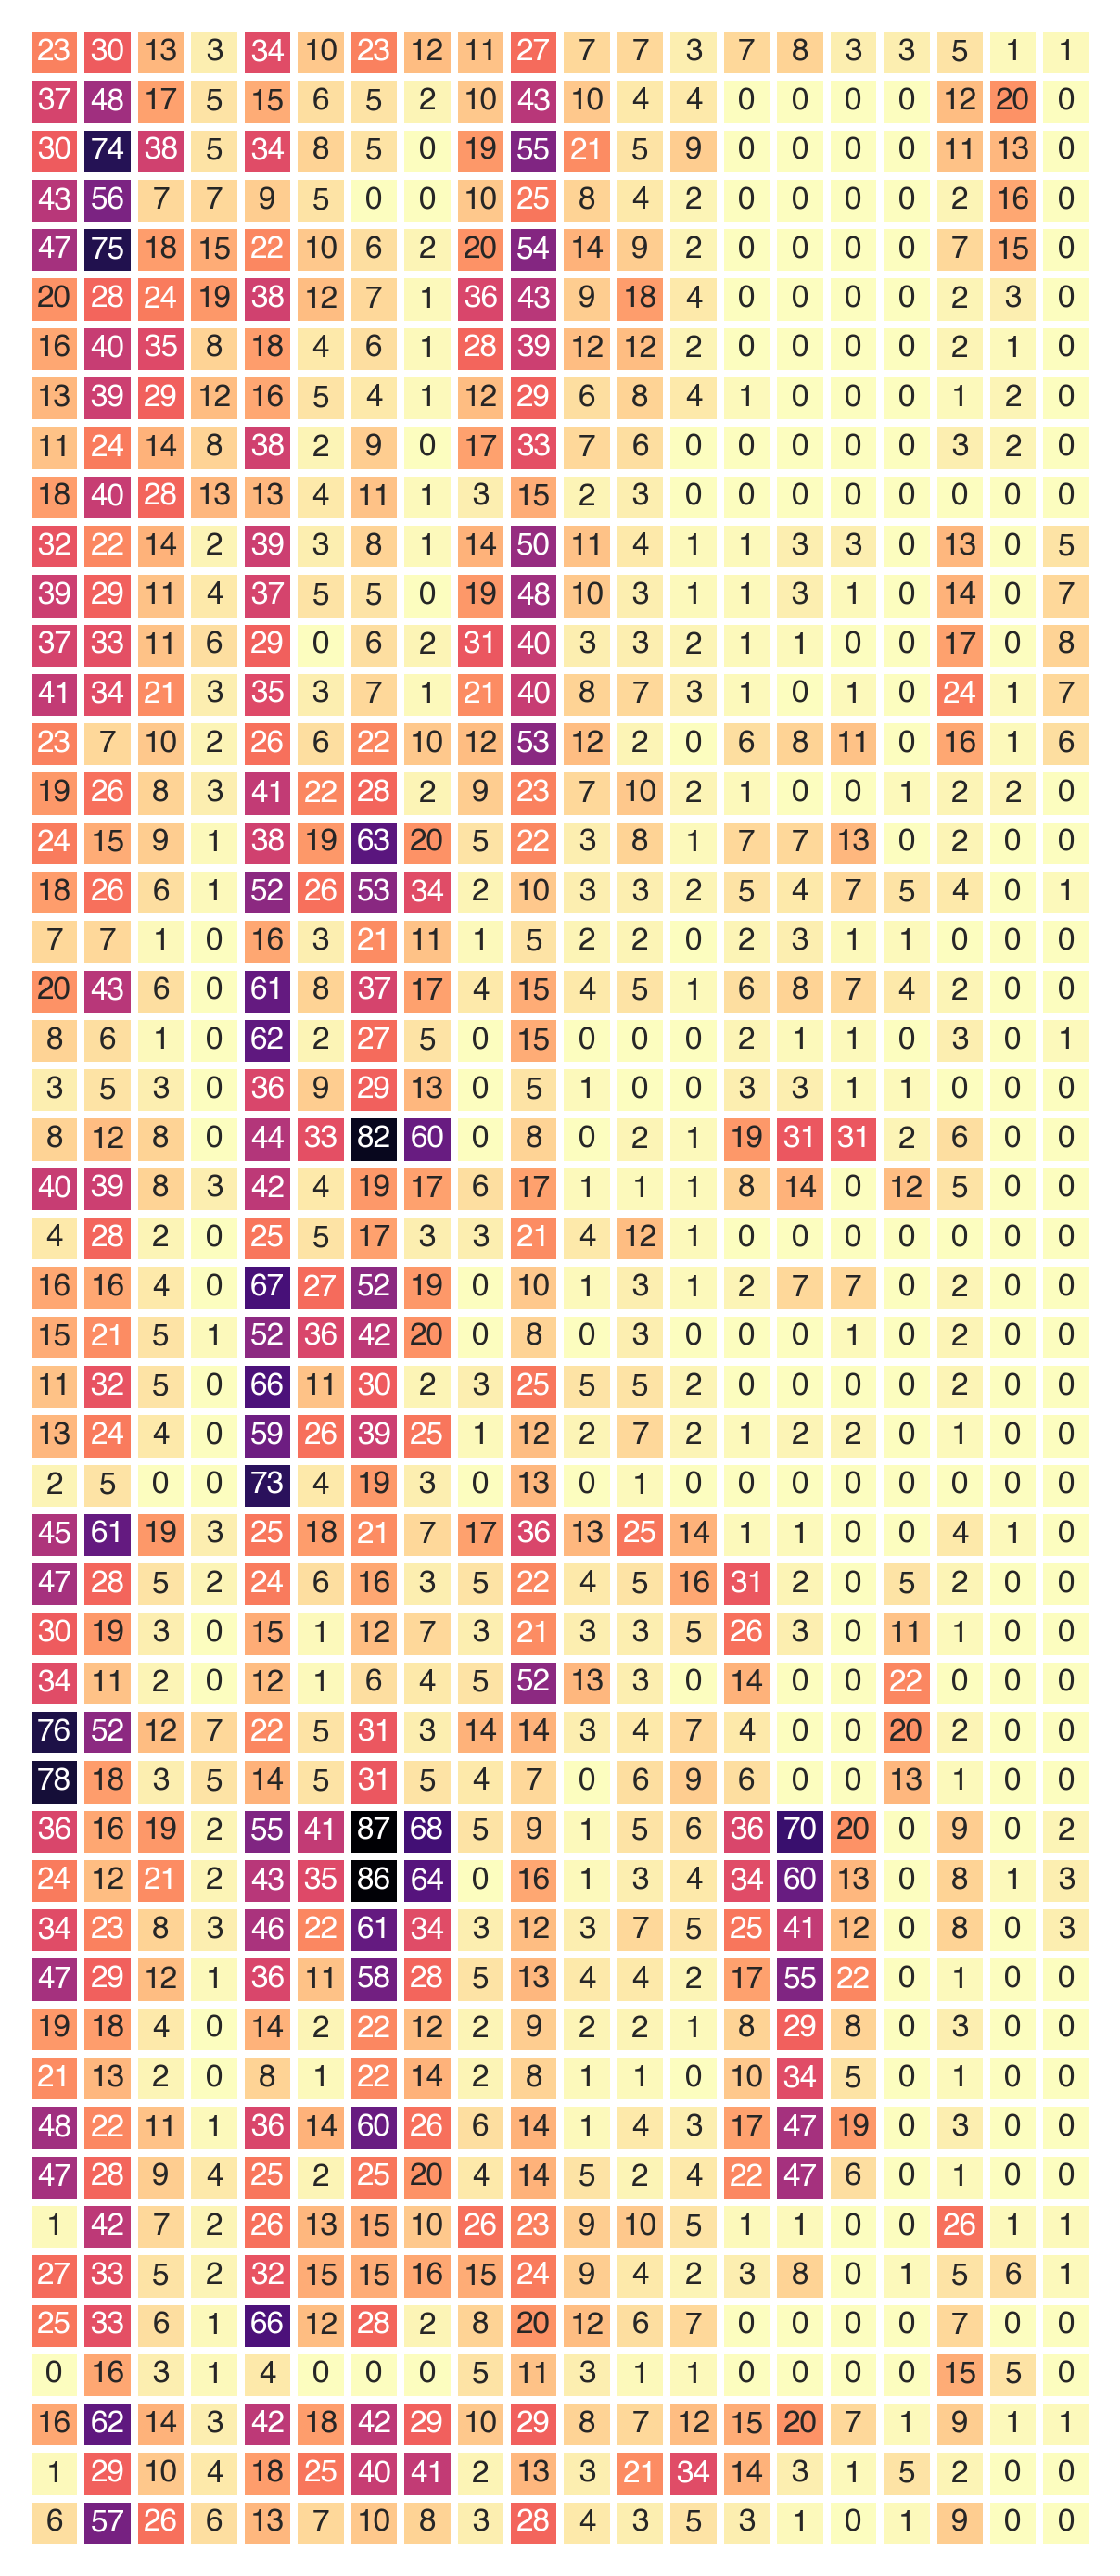

In [1067]:
fig, ax = plt.subplots(1, 1, figsize = (12*21/51, 12))
met_site_heatmap_plot(ax)

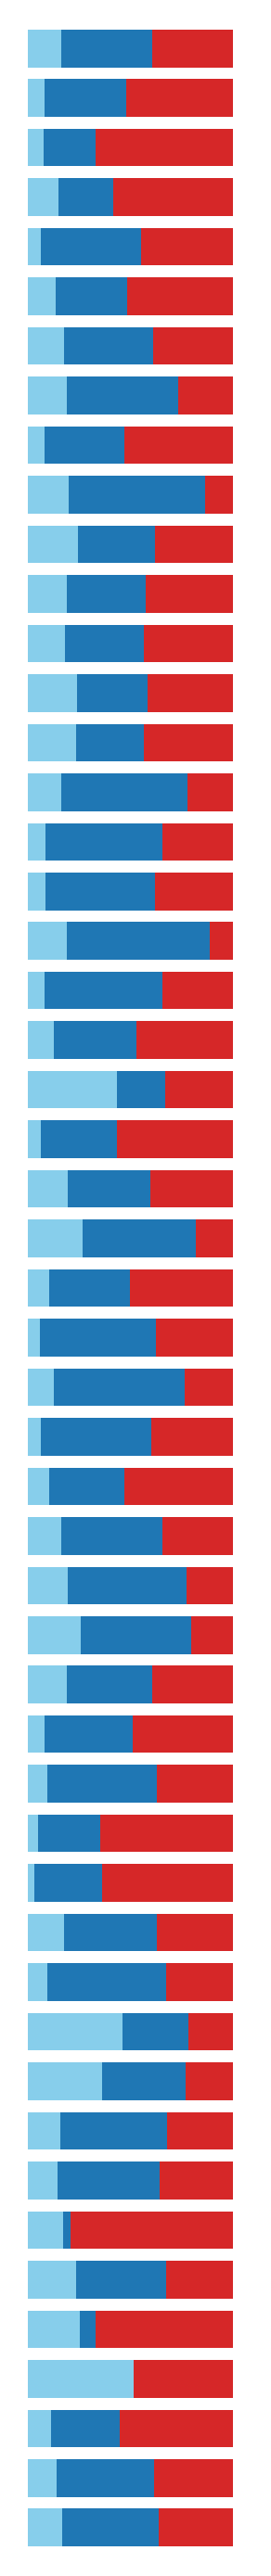

In [1068]:
fig, axes = plt.subplots(N_subtypes, 1, figsize = (1, 12))

for idx, subtype in enumerate(subtypes):
    sample_type(subtype, axes[idx])

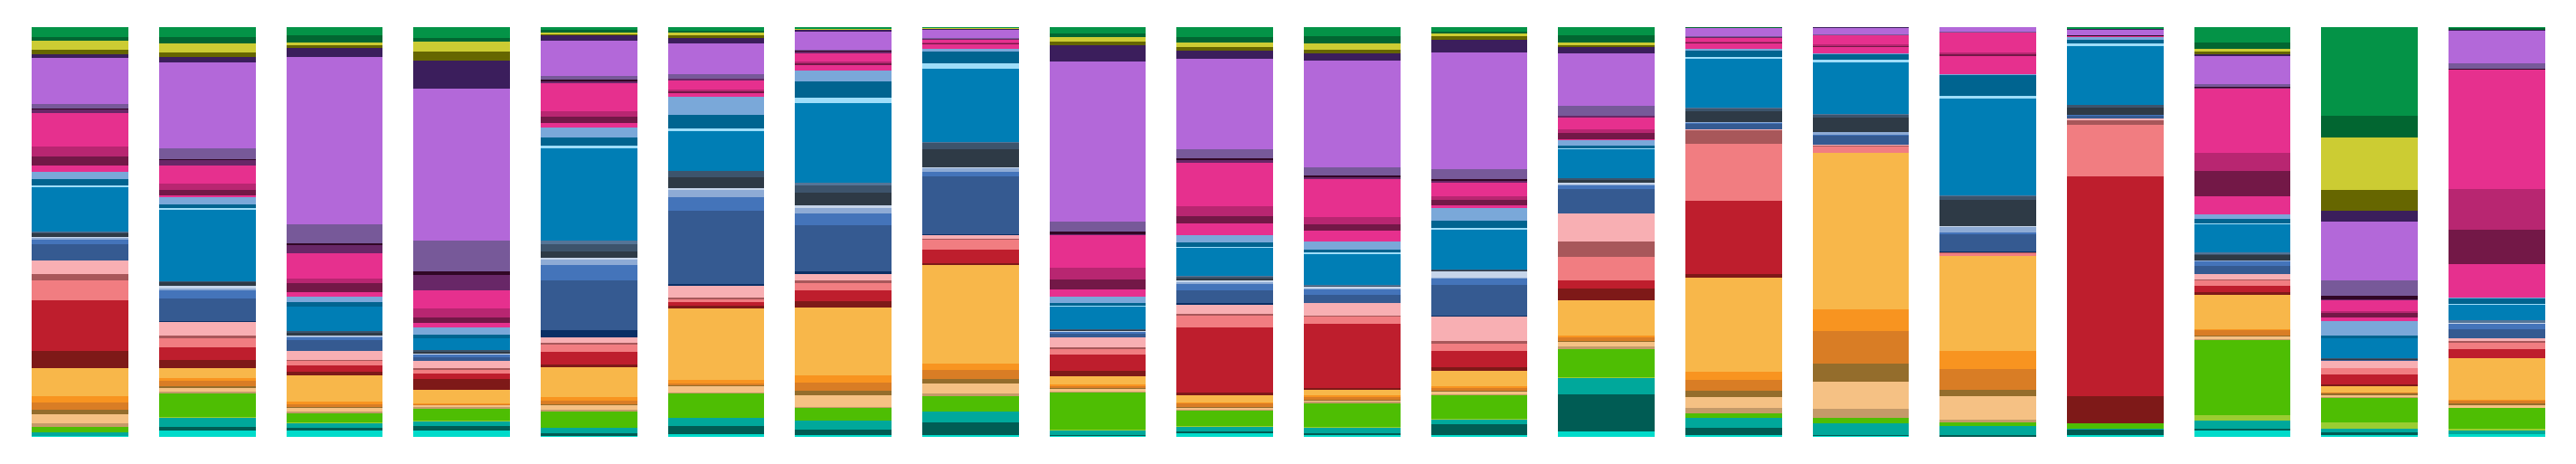

In [887]:
fig, axes = plt.subplots(1, 20, figsize = (12, 2))

for idx, subtype in enumerate(met_count_cols[1:]):
    met_cancer_bar_plot(subtype, axes[idx])



### Assembling everything

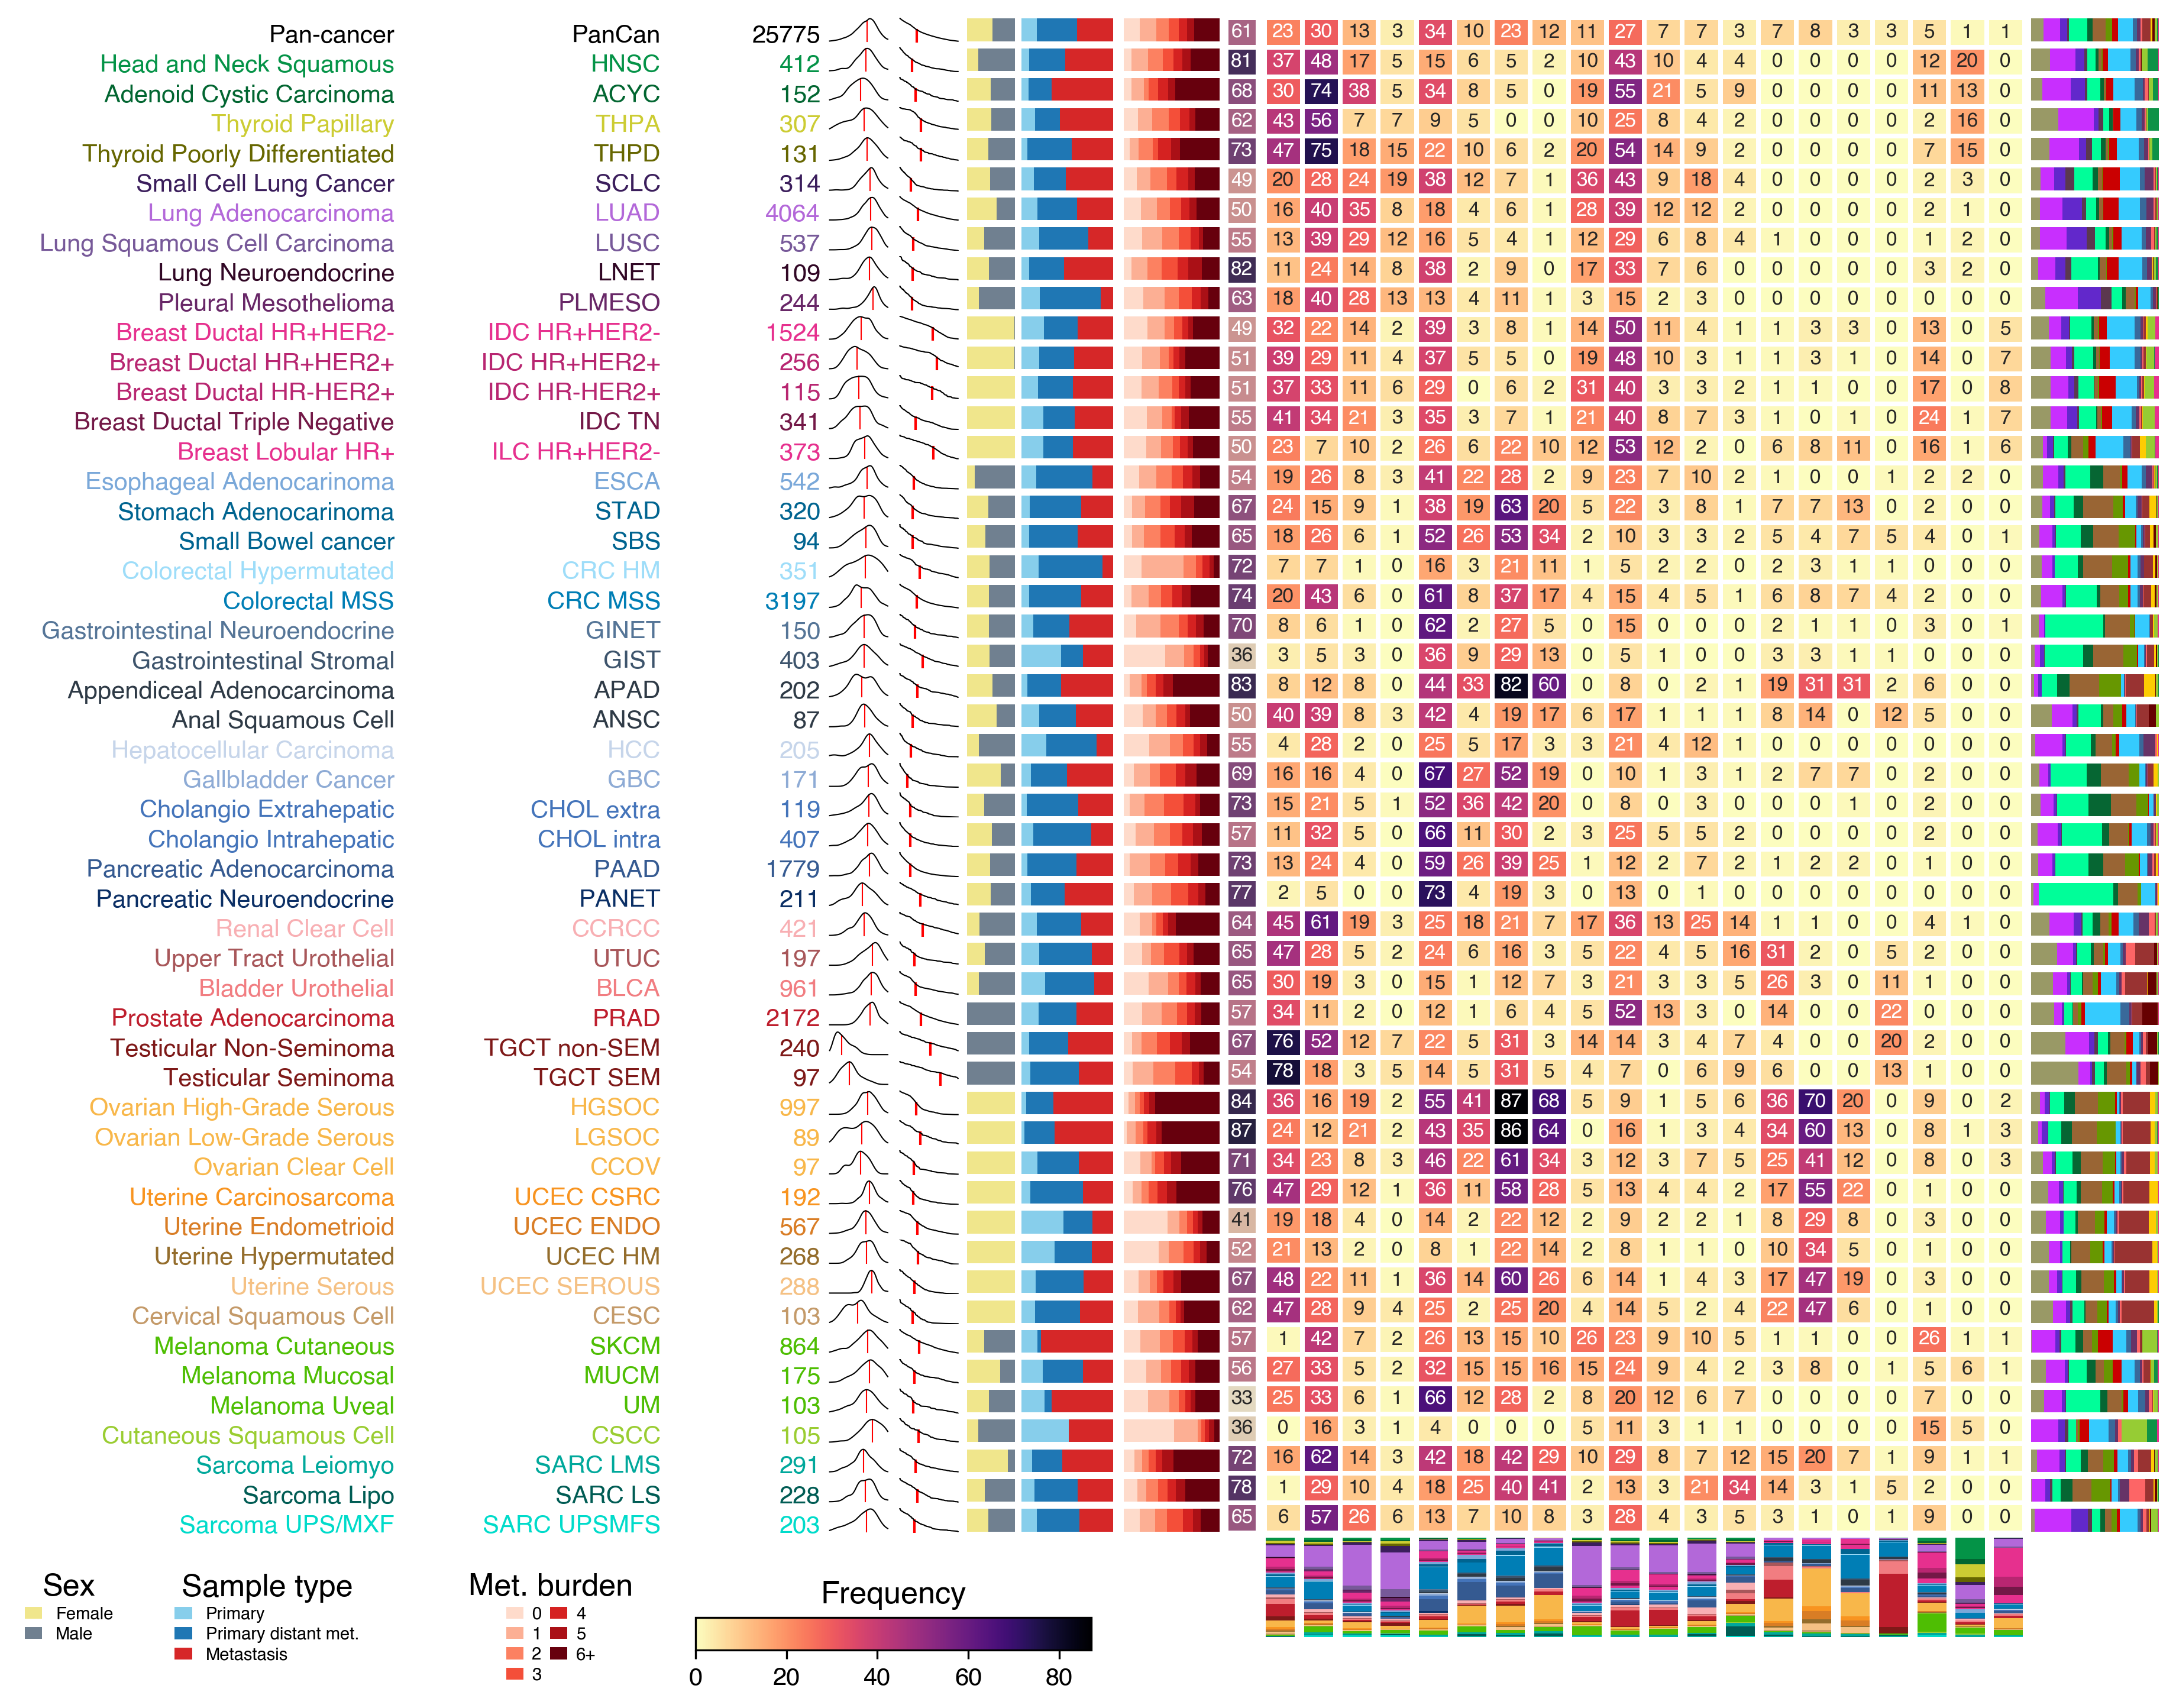

In [1069]:
w_margin = 0.2
h_margin = 0.2
width_ratios = np.array([20, 2, 2, 1.5, 3, 3, 1, 20 + 19 * w_margin, 4])
height_ratios = np.array([4] + [1]*51)

total_width = width_ratios.sum() + w_margin * (width_ratios.shape[0] - 1)
total_height = height_ratios.sum() + h_margin * (height_ratios.shape[0] - 1)

xs = np.insert(np.cumsum(width_ratios[:-1]  + w_margin), 0, 0)/total_width
ys = np.insert(np.cumsum(height_ratios[:-1]  + h_margin), 0, 0)/total_height
ys = ys[::-1]
ws = width_ratios/total_width
hs = height_ratios/total_height
hs = hs[::-1]
w_margin = w_margin/total_width
h_margin = h_margin/total_height

fig = plt.figure(figsize = (total_width * 0.18, total_height * 0.14))

ax_text = [fig.add_axes([xs[0],ys[i],ws[0],hs[i]]) for i in range(N_subtypes)]
ax_age = [fig.add_axes([xs[1],ys[i],ws[1],hs[i]]) for i in range(N_subtypes)]
ax_os = [fig.add_axes([xs[2],ys[i],ws[2],hs[i]]) for i in range(N_subtypes)]
ax_sex = [fig.add_axes([xs[3],ys[i],ws[3],hs[i]]) for i in range(N_subtypes)]
ax_sample = [fig.add_axes([xs[4],ys[i],ws[4],hs[i]]) for i in range(N_subtypes)]
ax_burden = [fig.add_axes([xs[5],ys[i],ws[5],hs[i]]) for i in range(N_subtypes)]
ax_unspec_hm = fig.add_axes([xs[6], ys[-2], ws[6], 1 - ys[-2]])
ax_met_hm = fig.add_axes([xs[7], ys[-2], ws[7], 1 - ys[-2]])
ax_met_site_distr = [fig.add_axes([xs[8],ys[i],ws[8],hs[i]]) for i in range(N_subtypes)]
ax_met_cancer_distr = [fig.add_axes([xs[7] + i * (ws[6] + w_margin),ys[-1],ws[6],hs[-1]]) for i in range(len(met_count_cols[1:]))]

for idx, subtype in enumerate(subtypes):
    text_plot(subtype, ax_text[idx])
    age_plot(subtype, ax_age[idx])
    os_plot(subtype, ax_os[idx])
    sex_plot(subtype, ax_sex[idx])
    sample_type(subtype, ax_sample[idx])
    metastasis_burden(subtype, ax_burden[idx])
    met_site_bar_plot(subtype, ax_met_site_distr[idx])
    
unspec_met_heatmap_plot(ax_unspec_hm)
met_site_heatmap_plot(ax_met_hm)

for idx, met_subtype in enumerate(met_count_cols[1:]):
    met_cancer_bar_plot(met_subtype, ax_met_cancer_distr[idx])


plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.labelspacing"] = 0.25
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.title_fontsize"] = 12.5
plt.rcParams["legend.loc"] = "upper left"

ax_sex[-1].legend(["Female", "Male"], title = "Sex", bbox_to_anchor = (-20,-1))
ax_sample[-1].legend(["Primary", "Primary distant met.", "Metastasis"], title = "Sample type", bbox_to_anchor = (-9,-1))
ax_burden[-1].legend(["0", "1", "2", "3", "4", "5", "6+"], title = "Met. burden", bbox_to_anchor = (-7,-1), ncol = 2, columnspacing = 0.5, handletextpad = 0.5)


data = met_count_table.to_numpy()
data = (data / data[:, -1:] * 100).astype('int32')
    
norm = plt.Normalize(0, data[1:, 1:-1].max())
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("magma_r", as_cmap=True), norm=norm)
sm.set_array([])

cax = fig.add_axes([0.26, -0.008, 0.2, 0.02])
cbar = plt.colorbar(sm, cax=cax, orientation = 'horizontal')
cbar.ax.set_title('Frequency', fontsize = 12.5)

fig.savefig("fig1.png", bbox_inches = "tight")

## Comparing FGA, WGD, and TMB values

In [985]:
# Processing our ASCETS-calculated WGD values
our_wgd = pd.read_csv("../GIIa3_github/Genomics-II-Group/Plot_2/Figure2B/tmb_high_and_wgd.csv")
our_wgd = our_wgd.loc[:, ["SUBTYPE", "SAMPLE_TYPE", "WGD"]]

## change subtype name from curated_subtype_display to curated_subtype
our_wgd = our_wgd.rename(columns = {"SUBTYPE": "curated_subtype_display"}).set_index("curated_subtype_display")
display_names = table1.loc[:, ["curated_subtype", "curated_subtype_display"]].set_index("curated_subtype_display")
our_wgd = our_wgd.join(display_names, on = "curated_subtype_display").set_index("curated_subtype")

## pivoting table for easier comparison
our_wgd = our_wgd.pivot(columns = ["SAMPLE_TYPE"])
our_wgd.columns = our_wgd.columns.map("_".join)
our_wgd = our_wgd.rename(columns = {"WGD_Metastasis":"our_metastasis_pc", "WGD_Primary":"our_primary_pc"})

# Importing the paper's WGD values
true_wgd = pd.read_csv("table2_1.csv")
true_wgd = true_wgd[true_wgd['alteration'] == 'WGD'].loc[:, ["tumor_type", "metastasis_pc", "primary_pc"]]

## converting percentages from strings to floats
true_wgd['primary_pc'] = true_wgd['primary_pc'].str.rstrip('%').astype('float') / 100.0
true_wgd['metastasis_pc'] = true_wgd['metastasis_pc'].str.rstrip('%').astype('float') / 100.0
true_wgd = true_wgd.rename(columns = {"tumor_type":"curated_subtype"}).set_index("curated_subtype")

# Join both tables
all_wgd = true_wgd.join(our_wgd, on = "curated_subtype")

### Computing WGDs from segmented CNV data

our_metastasis_pc2  our_primary_pc2  \
curated_subtype                                                                 
IDC_HR+HER2+                                        0.002021         0.001817   
IDC_HR+HER2-                                        0.002111         0.001082   
IDC_HR-HER2+                                        0.001741         0.001163   
IDC_TN                                              0.002011         0.001009   
ILC_HR+HER2-                                        0.001164         0.000336   
adenoid_cystic_carcinoma                            0.000283         0.000637   
anal_squamous_cell_carcinoma                        0.000807         0.002161   
appendiceal_adenocarcinoma                          0.000121         0.000034   
bladder_upper_tract_urothelial_carcinoma            0.001063         0.000451   
bladder_urothelial_carcinoma                        0.000660         0.000564   
cervical_squamous                                   0.000406         0.000493   
cholangio_extrahepatic                              0.000518         0.000240   
cholangio_intrahepatic                              0.000103         0.000383   
colorectal_cancer_hypermutant                       0.000032         0.000036   
colorectal_cancer_mss                               0.000888         0.000387   
cutaneous_squamous_cell_carcinoma                   0.000321         0.000324   
esophageal_adenocarcinoma                           0.000940         0.000653   
gallbladder_cancer                                  0.000703         0.000227   
gastrointestinal_neuroendocrine_tumor               0.000856         0.000542   
gastrointestinal_stromal_tumor                      0.000346         0.000254   
germ_cell_non_seminomatous                          0.001519         0.001941   
germ_cell_seminomatous                              0.001198         0.001376   
head_and_neck_squamous                              0.001057         0.000558   
hepatocellular_carcinoma                            0.002647         0.000583   
lung_adenocarcinoma                                 0.000934         0.000362   
lung_neuroendocrine                                 0.001390         0.000696   
lung_squamous_cell_carcinoma                        0.001409         0.001002   
melanoma_cutaneous                                  0.000637         0.000499   
melanoma_mucosal                                    0.001947         0.002104   
melanoma_uveal                                      0.003044         0.000554   
mesothelioma_pleural                                0.000326         0.000028   
ovarian_clear_cell                                  0.001231         0.000139   
ovarian_hg_serous                                   0.001374         0.001232   
ovarian_lg_serous                                   0.000161         0.000034   
pancreatic_adenocarcinoma                           0.000314         0.000151   
pancreatic_neuroendocrine                           0.000184         0.000043   
prostate_adenocarcinoma                             0.001444         0.000345   
renal_clear_cell                                    0.000100         0.000033   
sarcoma_leiomyo                                     0.001272         0.000949   
sarcoma_lipo                                        0.002004         0.002101   
sarcoma_ups/mxf                                     0.001014         0.001246   
small_bowel_cancer                                  0.000155         0.000211   
small_cell_lung_cancer                              0.001577         0.000784   
stomach_adenocarcinoma                              0.000597         0.000257   
thyroid_papillary                                   0.000080         0.000061   
thyroid_poorly_differentiated                       0.000086         0.000176   
uterine_carcinosarcoma                              0.001861         0.001242   
uterine_endometrioid                                0.000787         0.00

In [995]:
# Importing all segmented CNV data
cnv = pd.read_table("../GIIa3_github/Genomics-II-Group/Data/data_cna_hg19.seg", sep = "\t")
cnv = cnv.rename(columns = {"ID":"sample_id"})

# Computing WGDs
## removing sex chromosomes
cnv = cnv.loc[~cnv["chrom"].isin(["X", "Y"])]

## computing genome length fractions
cnv['length'] = cnv["loc.end"] - cnv["loc.start"]
all_lengths = cnv.groupby("sample_id").agg({"length": np.sum})
cnv = cnv.join(all_lengths, on="sample_id", rsuffix = "_total")
cnv["length_fraction"] = cnv["length"]/cnv["length_total"]

## adding curated_subtype, sample_type, and tumor_purity information
extra_info = table2.loc[:,["sample_id", "sample_type", "curated_subtype", "tumor_purity"]].set_index("sample_id")
cnv = cnv.join(extra_info, on = "sample_id")

## computing sample-wise average ratios
cnv['ratio'] = 2**cnv["seg.mean"]
ratio_avgs = cnv.groupby("sample_id").agg({"ratio": np.median})
cnv = cnv.join(ratio_avgs, on="sample_id", rsuffix = "_avg")

## centering sample-wise CN ratios
cnv['ratio'] = cnv['ratio'] - cnv["ratio_avg"] + 1

## cleaning up purity values
cnv["tumor_purity"] = cnv["tumor_purity"]/100
cnv.loc[cnv["tumor_purity"] == 0, "tumor_purity"] = 0.1
cnv.loc[cnv["tumor_purity"].isna(), "tumor_purity"] = 0.5

## computing purity-adjusted ratios
cnv["adj_ratio"] = (cnv["ratio"] + cnv["tumor_purity"] - 1)/cnv["tumor_purity"]

## cleaning up negative ratios
cnv.loc[cnv["adj_ratio"]<=0, "adj_ratio"] = 0.01

## filtering fractions based on copy number ratio
cnv["filtered_fractions"] = cnv["length_fraction"] * (cnv["adj_ratio"]>=0) * np.minimum(np.log2(cnv["adj_ratio"]), 1)**cnv["tumor_purity"]

## grouping, aggregation, table pivoting
cnv = cnv.groupby(["curated_subtype", "sample_type"]).agg({"filtered_fractions": np.sum})
cnv = cnv.reset_index(level=1).pivot(columns = ["sample_type"])
cnv.columns = cnv.columns.map('_'.join)
cnv = cnv.rename(columns = {"filtered_fractions_Metastasis":"our_metastasis_pc2",
                           "filtered_fractions_Primary":"our_primary_pc2"})

## getting sample sizes and calculating percentages
sample_sizes = table1.loc[:, ["curated_subtype", "primary_n", "metastasis_n"]].set_index("curated_subtype")
cnv = cnv.join(sample_sizes, on = "curated_subtype")
cnv["our_metastasis_pc2"] = cnv["our_metastasis_pc2"]/cnv["metastasis_n"]
cnv["our_primary_pc2"] = cnv["our_primary_pc2"]/cnv["primary_n"]

# Adding to all_wgd table for comparison
# all_wgd = all_wgd.join(cnv, on = "curated_subtype")

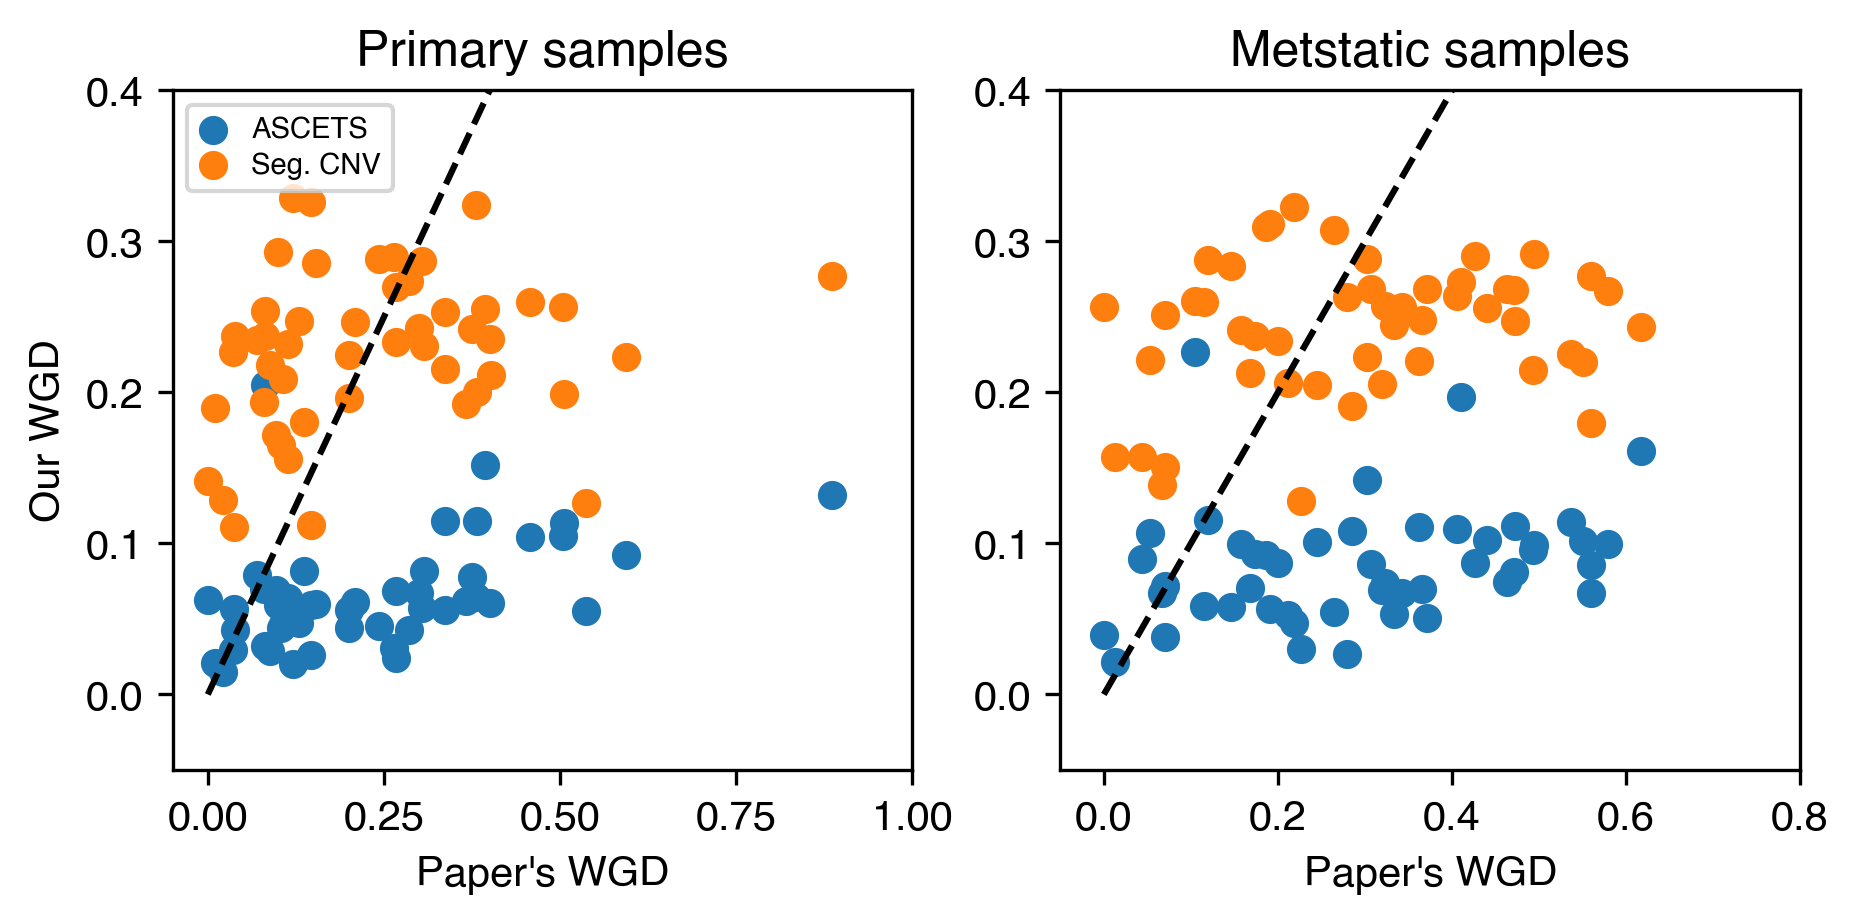

In [1070]:
fig, axes = plt.subplots(1,2, figsize = (7,3))

ax = axes[0]
ax.scatter(all_wgd["primary_pc"], all_wgd["our_primary_pc"])
ax.scatter(all_wgd["primary_pc"], cnv["our_primary_pc2"])
ax.legend(["ASCETS", "Seg. CNV"], frameon = True)

ax.plot([0,1], [0,1], c = "k", linestyle = "dashed")
ax.set_xlabel("Paper's WGD")
ax.set_ylabel("Our WGD")
ax.set_xlim([-0.05, 1])
ax.set_ylim([-0.05, 0.4])
ax.set_title("Primary samples")

ax = axes[1]
ax.scatter(all_wgd["metastasis_pc"], all_wgd["our_metastasis_pc"])
ax.scatter(all_wgd["metastasis_pc"], cnv["our_metastasis_pc2"])
ax.plot([0,1], [0,1], c = "k", linestyle = "dashed")
ax.set_xlabel("Paper's WGD")
ax.set_xlim([-0.05, 0.8])
ax.set_ylim([-0.05, 0.4])
ax.set_title("Metstatic samples");


### Comparing FGA and TMB values

In [293]:
cnv

our_metastasis_pc2  our_primary_pc2  \
curated_subtype                                                                 
IDC_HR+HER2+                                        0.183642         0.151987   
IDC_HR+HER2-                                        0.184500         0.145902   
IDC_HR-HER2+                                        0.191962         0.165199   
IDC_TN                                              0.239308         0.207001   
ILC_HR+HER2-                                        0.165212         0.134305   
adenoid_cystic_carcinoma                            0.095244         0.102678   
anal_squamous_cell_carcinoma                        0.200027         0.157166   
appendiceal_adenocarcinoma                          0.256707         0.256139   
bladder_upper_tract_urothelial_carcinoma            0.215740         0.154180   
bladder_urothelial_carcinoma                        0.218005         0.199892   
cervical_squamous                                   0.143920         0.127474   
cholangio_extrahepatic                              0.254425         0.293193   
cholangio_intrahepatic                              0.231912         0.244155   
colorectal_cancer_hypermutant                       0.142996         0.090105   
colorectal_cancer_mss                               0.218283         0.213448   
cutaneous_squamous_cell_carcinoma                   0.192132         0.188631   
esophageal_adenocarcinoma                           0.261783         0.250785   
gallbladder_cancer                                  0.230336         0.213792   
gastrointestinal_neuroendocrine_tumor               0.141568         0.123505   
gastrointestinal_stromal_tumor                      0.192378         0.108737   
germ_cell_non_seminomatous                          0.240099         0.215653   
germ_cell_seminomatous                              0.260048         0.181983   
head_and_neck_squamous                              0.210547         0.195533   
hepatocellular_carcinoma                            0.195150         0.168891   
lung_adenocarcinoma                                 0.233301         0.207034   
lung_neuroendocrine                                 0.236071         0.213834   
lung_squamous_cell_carcinoma                        0.258759         0.237301   
melanoma_cutaneous                                  0.165448         0.184017   
melanoma_mucosal                                    0.188090         0.170157   
melanoma_uveal                                      0.138046         0.095648   
mesothelioma_pleural                                0.212893         0.230163   
ovarian_clear_cell                                  0.133135         0.115066   
ovarian_hg_serous                                   0.237839         0.215505   
ovarian_lg_serous                                   0.171999         0.129767   
pancreatic_adenocarcinoma                           0.276794         0.282894   
pancreatic_neuroendocrine                           0.238835         0.191370   
prostate_adenocarcinoma                             0.261625         0.229623   
renal_clear_cell                                    0.180135         0.132881   
sarcoma_leiomyo                                     0.174441         0.150958   
sarcoma_lipo                                        0.082430         0.070642   
sarcoma_ups/mxf                                     0.181092         0.171597   
small_bowel_cancer                                  0.247300         0.246394   
small_cell_lung_cancer                              0.240810         0.222409   
stomach_adenocarcinoma                              0.218968         0.222123   
thyroid_papillary                                   0.103535         0.065063   
thyroid_poorly_differentiated                       0.113319         0.101102   
uterine_carcinosarcoma                              0.201617         0.171150   
uterine_endometrioid                                0.166892         0.08

In [1001]:
# Importing our TMB and FGA values
tmb_fga_table = pd.read_csv("../GIIa3_github/Genomics-II-Group/Plot_2/FGA/calculated_TMB_and_FGA.csv")  


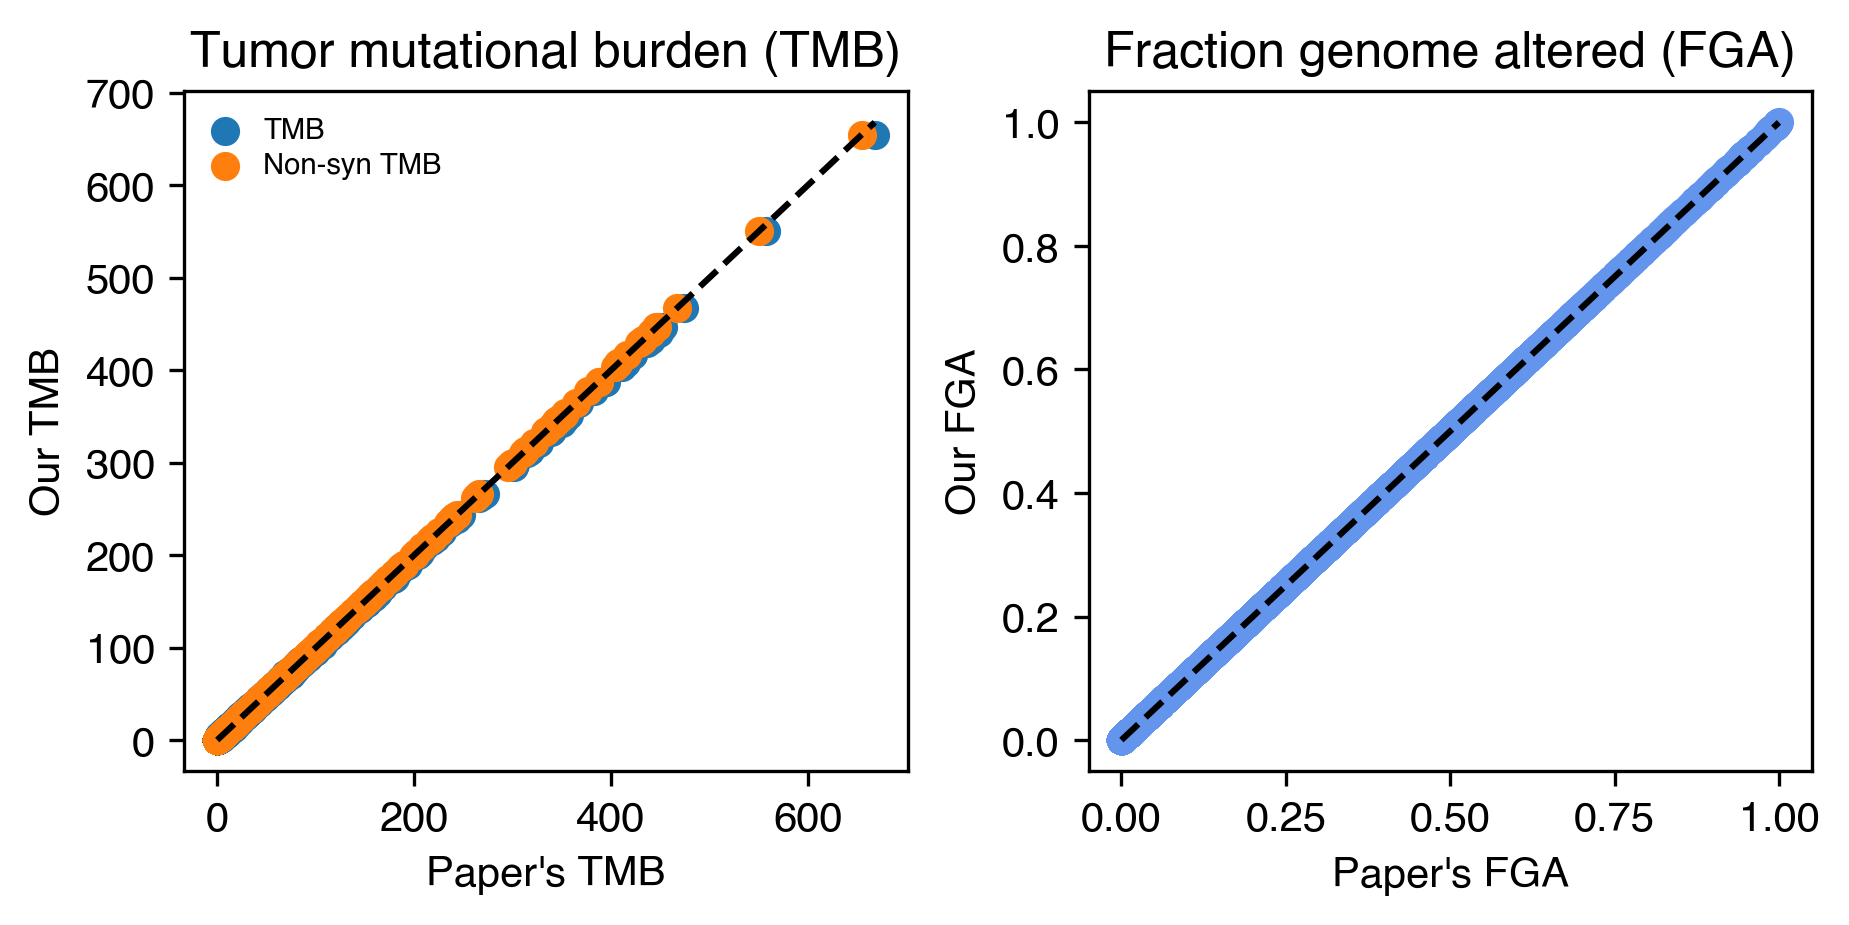

In [1002]:
fig, axes = plt.subplots(1,2,figsize = (7,3))

ax = axes[0]
ax.scatter(tmb_fga_table["Sup_TMB"], tmb_fga_table["Our_TMB"])
ax.scatter(tmb_fga_table["TMB_NONSYNONYMOUS"], tmb_fga_table["Our_TMB"])
ax.legend(["TMB", "Non-syn TMB"])
x_max = tmb_fga_table["Sup_TMB"].max()
ax.plot([0, x_max], [0, x_max], c = "k", linestyle = "dashed")
ax.set_title("Tumor mutational burden (TMB)")
ax.set_xlabel("Paper's TMB")
ax.set_ylabel("Our TMB")

ax = axes[1]
ax.scatter(tmb_fga_table["Sup_FGA"], tmb_fga_table["Our_FGA"], color = "cornflowerblue")
x_max = tmb_fga_table["Sup_FGA"].max()
ax.plot([0, x_max], [0, x_max], c = "k", linestyle = "dashed")
ax.set_title("Fraction genome altered (FGA)")
ax.set_xlabel("Paper's FGA")
ax.set_ylabel("Our FGA")

fig.subplots_adjust(wspace = 0.25)

## Figure 2B

In [1003]:
# Assembling the table
fig2b_table = table1.loc[:, ["curated_subtype", 
               "curated_subtype_display", 
               "total_n", "primary_n", "organ_system", 
               "metastasis_n", "color_subtype"]].copy()

fig2b_table = fig2b_table.set_index("curated_subtype", drop = False)
fig2b_table.index.names = ["subtype"]

# adding wgd
fig2b_table = fig2b_table.join(cnv.loc[:, ["our_metastasis_pc2", "our_primary_pc2"]], on = "curated_subtype")

# adding fga medians
tmb_fga_table["Our_FGA"] = tmb_fga_table["Our_FGA"]*100
tmb_fga_table = tmb_fga_table.rename(columns={"SUBTYPE":"curated_subtype_display"})
tmb_fga_table = tmb_fga_table.join(display_names, on="curated_subtype_display")
medians = tmb_fga_table.loc[tmb_fga_table["SAMPLE_TYPE"]=="Metastasis"]\
                        .groupby("curated_subtype").agg(fga_median=("Our_FGA",np.median))
fig2b_table = fig2b_table.join(medians, on = "curated_subtype")
median_max = fig2b_table.groupby("organ_system").agg(fga_median_max = ("fga_median", np.max))
fig2b_table = fig2b_table.join(median_max, on = "organ_system")
fig2b_table = fig2b_table.sort_values(by = ["fga_median_max", "fga_median"], ascending = False)

# adding fraction of samples with high tmb
tmb_fga_table["TMB_hi"] = tmb_fga_table["Our_TMB"]>10
num_hi_tmb = tmb_fga_table.groupby(["curated_subtype", "SAMPLE_TYPE"]) \
                         .agg(num_hi_TMB=("TMB_hi", np.sum)) \
                         .reset_index(1).pivot(columns = "SAMPLE_TYPE")
num_hi_tmb.columns = num_hi_tmb.columns.map('_'.join)

fig2b_table = fig2b_table.join(num_hi_tmb, on = "curated_subtype")
fig2b_table["num_hi_TMB_Metastasis"] = fig2b_table["num_hi_TMB_Metastasis"]/fig2b_table["metastasis_n"]
fig2b_table["num_hi_TMB_Primary"] = fig2b_table["num_hi_TMB_Primary"]/fig2b_table["primary_n"]


#### OncoKB Actionability

In [1004]:
oncokb_mut = pd.read_table("../GIIa3_github/Genomics-II-Group/Plot_2/OncoKB/oncokb_annotated_mutations.txt", sep = "\t")
oncokb_fus = pd.read_table("../GIIa3_github/Genomics-II-Group/Plot_2/OncoKB/oncokb_annotated_fusions.txt", sep = "\t")
oncokb_cna = pd.read_table("../GIIa3_github/Genomics-II-Group/Plot_2/OncoKB/oncokb_annotated_cna.txt", sep = "\t")

oncokb_mut = oncokb_mut[oncokb_mut["VARIANT_IN_ONCOKB"]==True]
oncokb_fus = oncokb_fus[oncokb_fus["VARIANT_IN_ONCOKB"]==True]
oncokb_cna = oncokb_cna[oncokb_cna["VARIANT_IN_ONCOKB"]==True]

subtype_info = table2.loc[:, ["sample_id", "curated_subtype", "sample_type"]]

oncokb_mut = oncokb_mut.merge(subtype_info, left_on="Tumor_Sample_Barcode", right_on="sample_id")
oncokb_fus = oncokb_fus.merge(subtype_info, left_on="Tumor_Sample_Barcode", right_on="sample_id")
oncokb_cna = oncokb_cna.merge(subtype_info, left_on="SAMPLE_ID", right_on="sample_id")

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (9,10,11,12,13,15,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [1005]:
# count mutations once per subtype/sample type combination (?)
oncokb_mut = oncokb_mut.drop_duplicates(["curated_subtype", "sample_type", "Hugo_Symbol", "HGVSp_Short"])
oncokb_fus = oncokb_fus.drop_duplicates(["curated_subtype", "sample_type", "Hugo_Symbol", "Fusion"])
oncokb_cna = oncokb_cna.drop_duplicates(["curated_subtype", "sample_type", "HUGO_SYMBOL", "ALTERATION"])

In [1006]:
oncokb_mut = oncokb_mut.groupby(["curated_subtype", "sample_type"]).agg(
                                         Oncogenic=("ONCOGENIC", lambda x: x.str.match("Oncogenic").sum()),
                                         L1=("LEVEL_1", lambda x: x.notna().sum()),
                                         L2=("LEVEL_2", lambda x: x.notna().sum()),
                                         L3A=("LEVEL_3A", lambda x: x.notna().sum()),
                                         L3B=("LEVEL_3B", lambda x: x.notna().sum()),
                                         L4=("LEVEL_4", lambda x: x.notna().sum()),
                                         VUS=("ONCOGENIC", lambda x: x.isin(["Inconclusive", "Unknown"]).sum()),
                                         NA=("HIGHEST_LEVEL", lambda x: x.isna().sum()))
oncokb_fus = oncokb_fus.groupby(["curated_subtype", "sample_type"]).agg(
                                         Oncogenic=("ONCOGENIC", lambda x: x.str.match("Oncogenic").sum()),
                                         L1=("LEVEL_1", lambda x: x.notna().sum()),
                                         L2=("LEVEL_2", lambda x: x.notna().sum()),
                                         L3A=("LEVEL_3A", lambda x: x.notna().sum()),
                                         L3B=("LEVEL_3B", lambda x: x.notna().sum()),
                                         L4=("LEVEL_4", lambda x: x.notna().sum()),
                                         VUS=("ONCOGENIC", lambda x: x.isin(["Inconclusive", "Unknown"]).sum()),
                                         NA=("HIGHEST_LEVEL", lambda x: x.isna().sum()))
oncokb_cna = oncokb_cna.groupby(["curated_subtype", "sample_type"]).agg(
                                         Oncogenic=("ONCOGENIC", lambda x: x.str.match("Oncogenic").sum()),
                                         L1=("LEVEL_1", lambda x: x.notna().sum()),
                                         L2=("LEVEL_2", lambda x: x.notna().sum()),
                                         L3A=("LEVEL_3A", lambda x: x.notna().sum()),
                                         L3B=("LEVEL_3B", lambda x: x.notna().sum()),
                                         L4=("LEVEL_4", lambda x: x.notna().sum()),
                                         VUS=("ONCOGENIC", lambda x: x.isin(["Inconclusive", "Unknown"]).sum()),
                                         NA=("HIGHEST_LEVEL", lambda x: x.isna().sum()))

In [1007]:
OncoKB = oncokb_mut.merge(oncokb_cna, left_index = True, right_index = True, suffixes =("_mut", "_cna"))
OncoKB = OncoKB.merge(oncokb_fus, left_index = True, right_index = True)

OncoKB["Oncogenic_total"] = OncoKB.loc[:, OncoKB.columns.str.contains("Onco")].sum(1)
OncoKB["L1_total"] = OncoKB.loc[:, OncoKB.columns.str.contains("L1")].sum(1)
OncoKB["L2_total"] = OncoKB.loc[:, OncoKB.columns.str.contains("L2")].sum(1)
OncoKB["L3A_total"] = OncoKB.loc[:, OncoKB.columns.str.contains("L3A")].sum(1)
OncoKB["L4_total"] = OncoKB.loc[:, OncoKB.columns.str.contains("L4")].sum(1)
OncoKB["VUS_total"] = OncoKB.loc[:, OncoKB.columns.str.contains("VUS")].sum(1)
OncoKB["None_total"] = OncoKB.loc[:, OncoKB.columns.str.contains("None")].sum(1)

OncoKB = OncoKB.loc[:, OncoKB.columns.str.contains("_total")]
OncoKB = OncoKB.div(OncoKB.sum(1), axis = 0)

In [1008]:
OncoKB = OncoKB.reset_index(1).pivot(columns = "sample_type")

OncoKB = OncoKB.reindex(subtypes[1:])
OncoKB[OncoKB.isna()] = 0

OncoKB.loc[:, ("None_total", "Metastasis")] = np.round(1 - OncoKB.swaplevel(axis = 1).loc[:, "Metastasis"].sum(1))
OncoKB.loc[:, ("None_total", "Primary")] = np.round(1 - OncoKB.swaplevel(axis = 1).loc[:, "Primary"].sum(1))

In [1009]:
def actionability_plot(y_positions, y_lim, ax, h=0.4, p=0.04):
    ax.set_title("Actionability", fontsize = 7)
    actions = ['L1_total', 'L2_total', 'L3A_total', 
              'L4_total','Oncogenic_total', 'VUS_total', 'None_total']
    colors = ["tab:green", "tab:blue", "tab:purple", 
              "tab:pink", "darkslategray", "blanchedalmond", "lightgrey", "white"]

    prim_left, meta_left = 0, 0
    for idx, action in enumerate(actions):
        ax.barh(y = y_positions+h/2+p/2, height = h, left = prim_left,
                            width = OncoKB[(action, "Primary")], 
                            color = colors[idx])
        ax.barh(y = y_positions-h/2-p/2, height = h, left = meta_left,
                            width = OncoKB[(action, "Metastasis")],
                            color = colors[idx],
                            label = "_nolegend_")
        prim_left = prim_left + OncoKB[(action, "Primary")]
        meta_left = meta_left + OncoKB[(action, "Metastasis")]

    ax.set_ylim(y_lim)
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([0, 1], fontsize = 7)
    ax.set_xlim([0, 1])
    ax.set_xlabel("Fraction", fontsize = 7);

In [1010]:
def text_plot(y_positions, y_lim, ax):
    subtypes = fig2b_table.index.to_list()
    for subtype, y_pos in zip(subtypes, y_positions):
        title = fig2b_table.loc[subtype, "curated_subtype_display"]
        sample_size = fig2b_table.loc[subtype, "total_n"]
        text = f"{title} ({str(sample_size)})"
        ax.text(1, y_pos, text, 
                ha = "right", va = "center", 
                color = fig2b_table.loc[subtype, "color_subtype"])
    ax.set_ylim(y_lim)
    ax.set_xlim([0, 1])
    ax.axis('off')

In [1011]:
def two_bars_plot(prim_value, meta_value, annot, y_positions, y_lim, ax, xlabel, x_max = False, h=0.4, title = ""):
    ax.set_title(title, fontsize = 7)
    # grey areas in background
    for idx, y_pos in enumerate(y_positions):
        if idx % 2 == 0:
            ax.axhspan(y_pos-0.5, y_pos+0.5, color = "lightgrey")
    
    # draw bars
    colors = fig2b_table["color_subtype"]
    subtypes = fig2b_table.index.to_list()
    
    prim_bars = ax.barh(y = y_centers+h/2, height = h,
                        width = fig2b_table[prim_value], 
                        color = "white", edgecolor = colors)
    meta_bars = ax.barh(y =  y_centers-h/2, height = h,
                        width = fig2b_table[meta_value],
                        color = colors)
    
    if annot:
        for subtype,y_pos in zip(subtypes, y_positions):
            prim_x = fig2b_table.loc[subtype, "primary_n"]
            meta_x = fig2b_table.loc[subtype, "metastasis_n"]
            ax.text(prim_x-100 if prim_x>1400 else prim_x+100, 
                    y_pos+h/2, str(prim_x),
                    ha = "right" if prim_x>1400 else "left", 
                    va = "center", fontsize = 6)
            ax.text(meta_x-100 if meta_x>1400 else meta_x+100, 
                    y_pos-h/2, str(meta_x),
                    ha = "right" if meta_x>1400 else "left", 
                    va = "center", fontsize = 6)

    ax.set_ylim(y_lim)
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    
    if not x_max:
        x_max = fig2b_table.loc[:, [prim_value, meta_value]].max().max()
    ax.set_xticks([0, x_max])
    ax.set_xticklabels([0, x_max], fontsize = 7)
    ax.set_xlim([0, 1.05*x_max])
    ax.set_xlabel(xlabel, fontsize = 7);

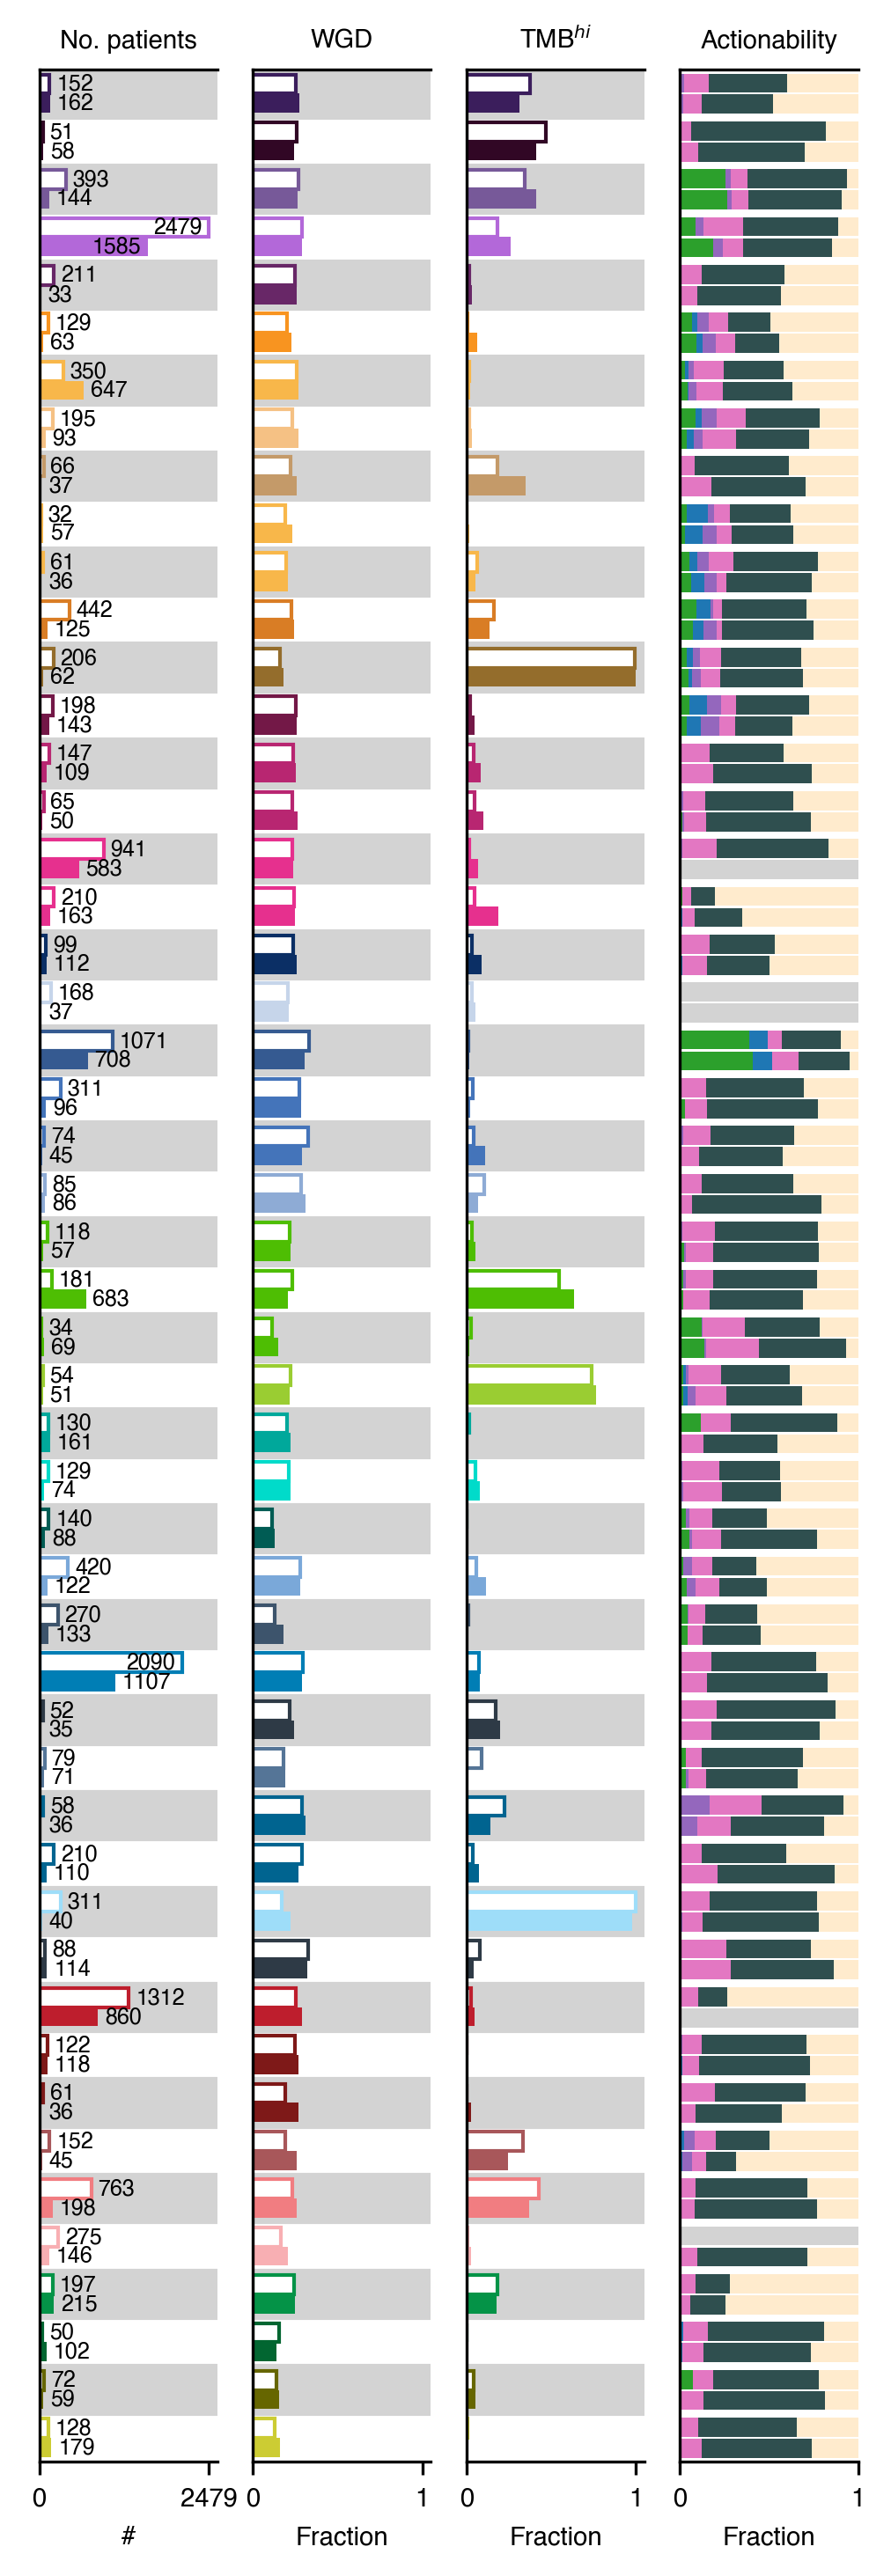

In [1012]:
fig, ax = plt.subplots(1,4, figsize = (4, 12))

two_bars_plot(prim_value = "primary_n", 
              meta_value = "metastasis_n", 
              annot=True, 
              y_positions = np.arange(50, 0, -1), 
              y_lim = [0.5, 50.5], 
              ax = ax[0], 
              xlabel = "#", 
              h=0.4,
              title = "No. patients")

two_bars_plot(prim_value = "our_primary_pc2", 
              meta_value = "our_metastasis_pc2", 
              annot = False, 
              y_positions = np.arange(50, 0, -1), 
              y_lim = [0.5, 50.5], 
              ax = ax[1], 
              xlabel = "Fraction", 
              x_max = 1,
              h=0.4,
              title = "WGD")

two_bars_plot(prim_value = "num_hi_TMB_Primary", 
              meta_value = "num_hi_TMB_Metastasis", 
              annot = False, 
              y_positions = np.arange(50, 0, -1), 
              y_lim = [0.5, 50.5], 
              ax = ax[2], 
              xlabel = "Fraction", 
              x_max = 1,
              h=0.4,
              title = r"TMB$^{hi}$")

actionability_plot(y_positions=np.arange(50, 0, -1), 
                   y_lim = [0.5, 50.5], 
                   ax=ax[3], h=0.4, p=0.04)


### FGA violin plots

In [1013]:
fga_data = tmb_fga_table.groupby(["curated_subtype", "SAMPLE_TYPE"])["Our_FGA"].apply(pd.Series.to_list).to_dict()
tmb_data = tmb_fga_table.groupby(["curated_subtype", "SAMPLE_TYPE"])["Our_TMB"].apply(pd.Series.to_list).to_dict()

# adjust color contrasts for median lines
cols = [h.strip("#") for h in fig2b_table['color_subtype']]
cols_rgb = np.array([[int(h[i:i+2], 16) for i in (0,2,4)] for h in cols])
fig2b_table["median_line_cols"] = ['white' if x else 'black' for x in (cols_rgb @ np.array([[0.299],[0.587],[0.114]]))<70]

In [1014]:

def violin_plot(data, y_positions, y_lim, ax, xlabel, x_max=False, logscale = False, title = ""):
    ax.set_title(title, fontsize = 7)
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    if x_max:
        ax.set_xlim([0, 1.05*x_max])
        ax.set_xticks([0, x_max])
        ax.set_xticklabels([0, x_max], fontsize = 7)
    ax.set_xlabel(xlabel, fontsize = 7)
    ax.set_ylim(y_lim)
    if logscale:
        ax.set_xscale('log')
        ax.set_xlim([0.1, 700])
        ax.set_xticks([0.1, 10, 100])
        ax.set_xticklabels([0, 10, 100], fontsize = 7)
    
    # grey areas in background 
    for idx, y_pos in enumerate(y_positions):
        if idx % 2 == 0:
            ax.axhspan(y_pos-0.5, y_pos+0.5, color = "lightgrey")
    
    # get data
    subtypes = fig2b_table.index.to_list()
    prim_data = [data[(st, "Primary")] for st in subtypes]
    meta_data = [data[(st, "Metastasis")] for st in subtypes]

    # draw violin plots
    prim_vp = ax.violinplot(prim_data, y_positions, 
                            vert = False, showextrema=False, showmeans=False, showmedians=True, widths = 0.8);
    meta_vp = ax.violinplot(meta_data, y_positions, 
                            vert = False, showextrema=False, showmeans=False, showmedians=True, widths = 0.8);
    
    # fix median lines width and color
    prim_vp['cmedians'].set_linewidths(1)
    prim_vp['cmedians'].set_colors("k")
    meta_vp['cmedians'].set_linewidths(1)
    meta_vp['cmedians'].set_colors(fig2b_table["median_line_cols"])
    

    for idx, (prim_b, meta_b, st) in enumerate(zip(prim_vp['bodies'], meta_vp['bodies'], subtypes)):
        # fix colors and line widths
        type_col = fig2b_table.loc[st, "color_subtype"]
        
        prim_b.set_edgecolor(type_col)
        prim_b.set_facecolor("white")
        prim_b.set_linewidths(1.25)
        prim_b.set_alpha(1)

        meta_b.set_edgecolor(type_col)
        meta_b.set_facecolor(type_col)
        meta_b.set_linewidths(1.25)
        meta_b.set_alpha(0.8)

        # split violins in half and fix median lines
        # primary data
        ## get mean y position
        path = prim_b.get_paths()[0].vertices
        m = np.mean(path[:, 1])
        # modify the paths to not go below mean y position
        prim_b.get_paths()[0].vertices[:, 1] = np.clip(path[:, 1], m, +np.inf)

        ## fix the median lines
        mverts = prim_vp["cmedians"].get_paths()[idx].vertices
        x_idx = np.argsort(np.abs(path[:, 0] - mverts[0,0]))[:3]
        mverts[0, 1] = path[x_idx, 1].min()
        mverts[1,1] = path[x_idx, 1].max()
        prim_vp["cmedians"].get_paths()[idx].vertices = mverts
        
        # metastasis data
        path = meta_b.get_paths()[0].vertices
        m = np.mean(path[:, 1])
        meta_b.get_paths()[0].vertices[:, 1] = np.clip(path[:, 1], -np.inf, m)

        mverts = meta_vp["cmedians"].get_paths()[idx].vertices
        x_idx = np.argsort(np.abs(path[:, 0] - mverts[0,0]))[:3]
        mverts[0, 1] = path[x_idx, 1].min()
        mverts[1,1] = path[x_idx, 1].max()
        meta_vp["cmedians"].get_paths()[idx].vertices = mverts


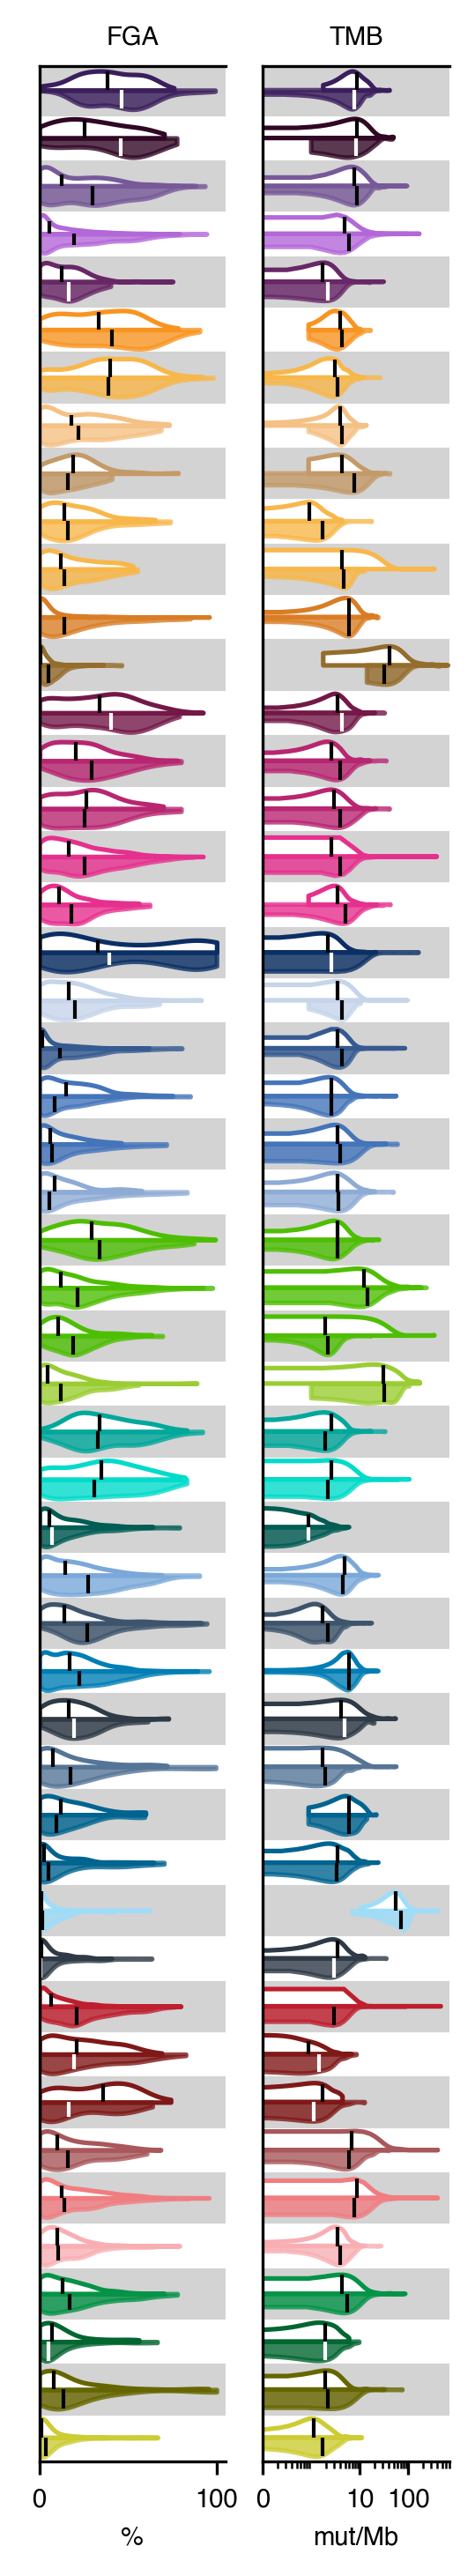

In [1015]:
fig, ax = plt.subplots(1,2,figsize = (2, 12))

violin_plot(data = fga_data, 
            y_positions = np.arange(50, 0, -1), 
            y_lim = [0.5,50.5], 
            ax = ax[0], 
            xlabel = "%", 
            x_max= 100,
            title = "FGA")

violin_plot(data = tmb_data, 
            y_positions = np.arange(50, 0, -1), 
            y_lim = [0.5,50.5], 
            ax = ax[1], 
            xlabel = "mut/Mb", 
            logscale=True,
            title = "TMB")

### Arm-level CNAs

In [1016]:
cna = pd.read_csv("../GIIa3_github/Genomics-II-Group/Plot_2/aSCNAs/subtype_mean_arm_level_cna.csv") 
cna = cna.merge(display_names, left_on="SUBTYPE", right_index = True).set_index(["curated_subtype", "SAMPLE_TYPE"])

chrom_arms = ['X1p', 'X1q',
              'X2p', 'X2q',
              'X3p', 'X3q', 
              'X4p', 'X4q', 
              'X5p', 'X5q', 
              'X6p', 'X6q', 
              'X7p', 'X7q',
              'X8p', 'X8q', 
              'X9p', 'X9q', 
              'X10p', 'X10q', 
              'X11p', 'X11q', 
              'X12p', 'X12q', 
              'X13q',
              'X14q', 
              'X15q', 
              'X16p', 'X16q', 
              'X17p', 'X17q', 
              'X18p', 'X18q', 
              'X19p', 'X19q',  
              'X20p', 'X20q', 
              'X21q', 
              'X22q']


In [1017]:
def cna_heatmap_plot(subtype, ax):
    data = cna.loc[[(subtype, "Primary"), (subtype, "Metastasis")], chrom_arms].to_numpy()
    sns.heatmap(data, cmap=sns.color_palette("RdBu_r", 20), 
            center = 0, lw = 0.5, ax = ax, cbar = False,
            vmin = -0.26, vmax = 0.26)
    ax.axis('off');

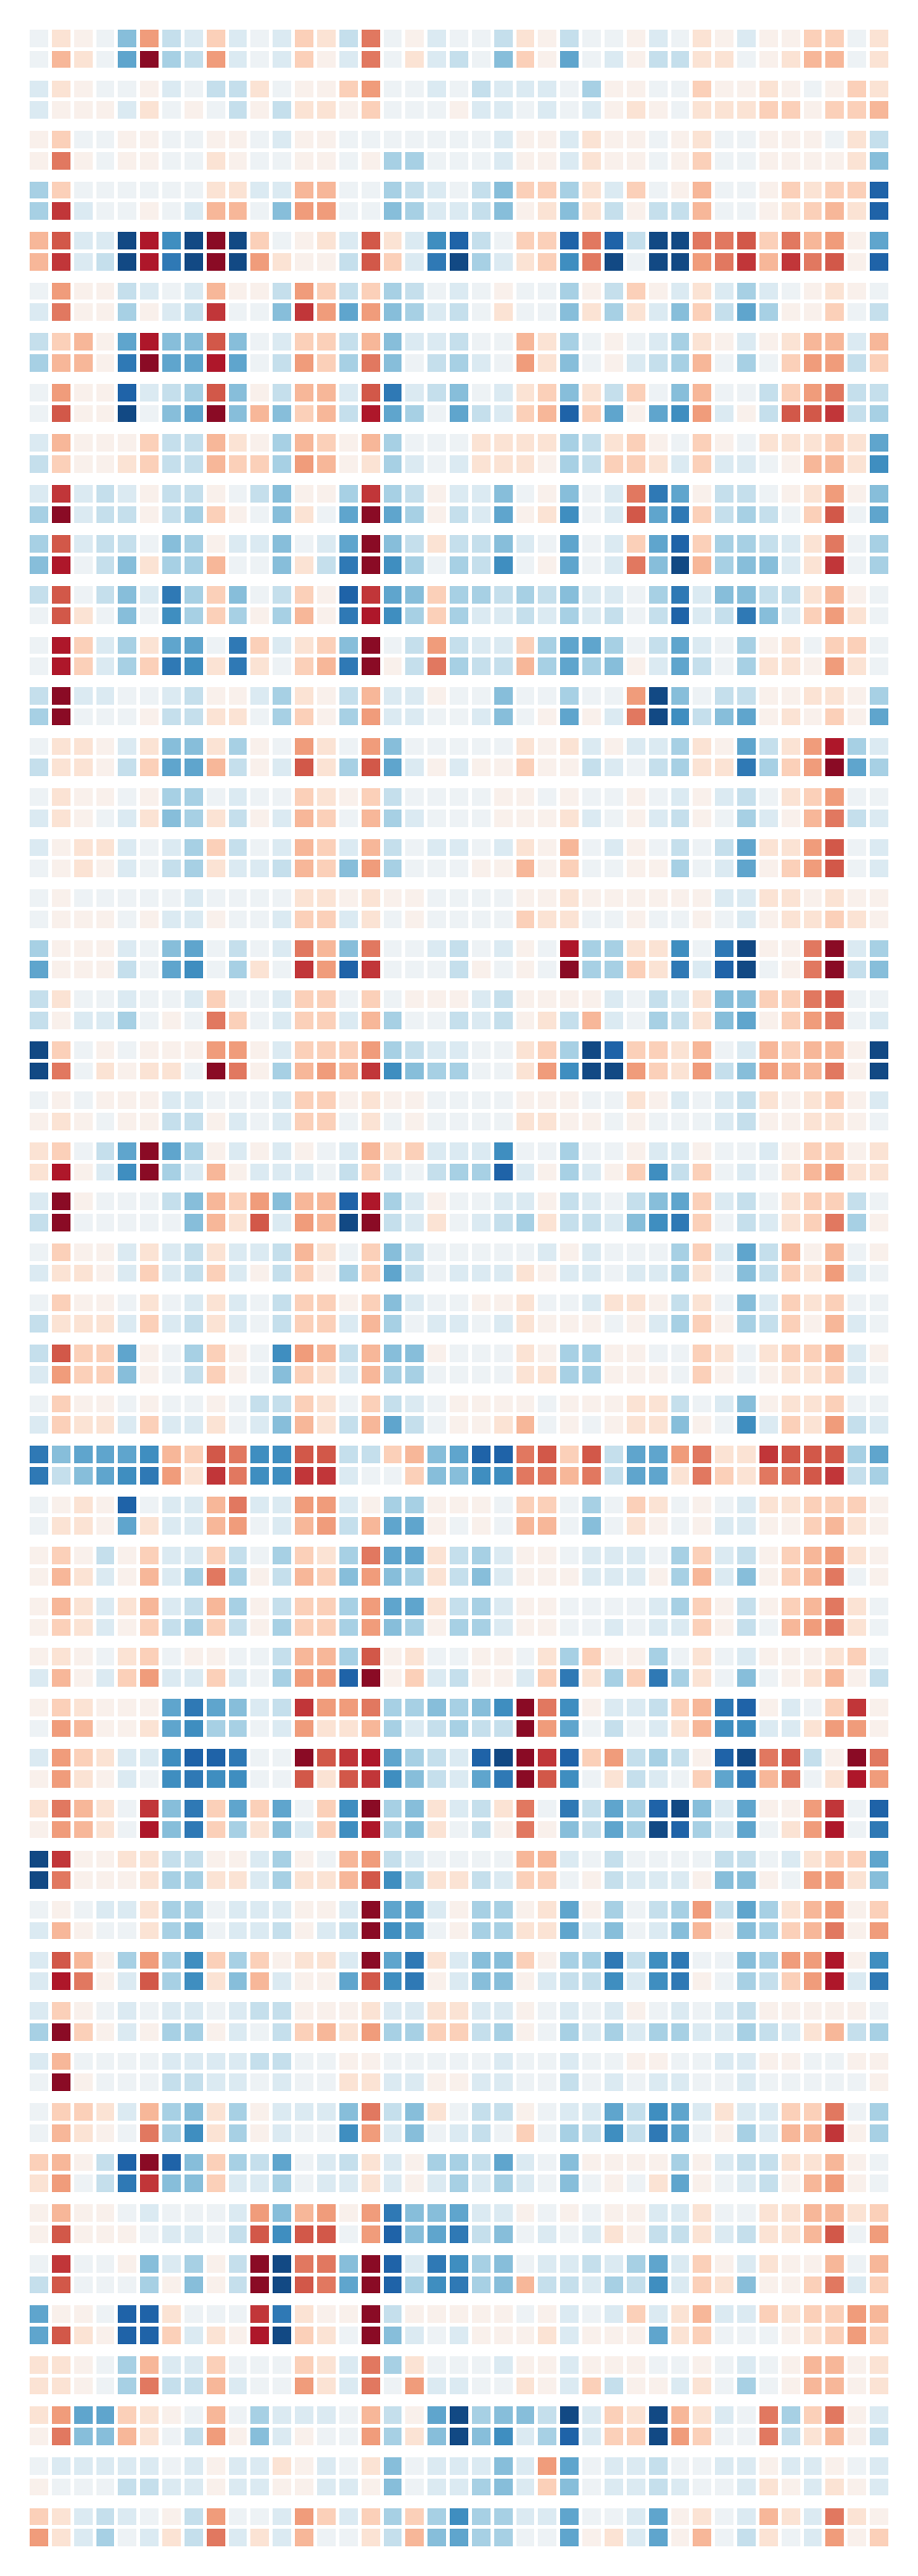

In [1071]:
fig, axes = plt.subplots(50,1, figsize = (4, 12))

for ax, st in zip(axes, subtypes[1:]):
    cna_heatmap_plot(st, ax)


### Assembling Figure 2B

In [1034]:
chrom_num = [x[1:] for x in chrom_arms]

In [1036]:
heatmap_top = ['1p',
 '',
 '2p',
 '',
 '3p',
 '',
 '4p',
 '',
 '5p',
 '',
 '6p',
 '',
 '7p',
 '',
 '8p',
 '',
 '9p',
 '',
 '10p',
 '',
 '11p',
 '',
 '12p',
 '',
 '13q',
 '14q',
 '15q',
 '16p',
 '',
 '17p',
 '',
 '18p',
 '',
 '19p',
 '',
 '20p',
 '',
 '21q',
 '22q']

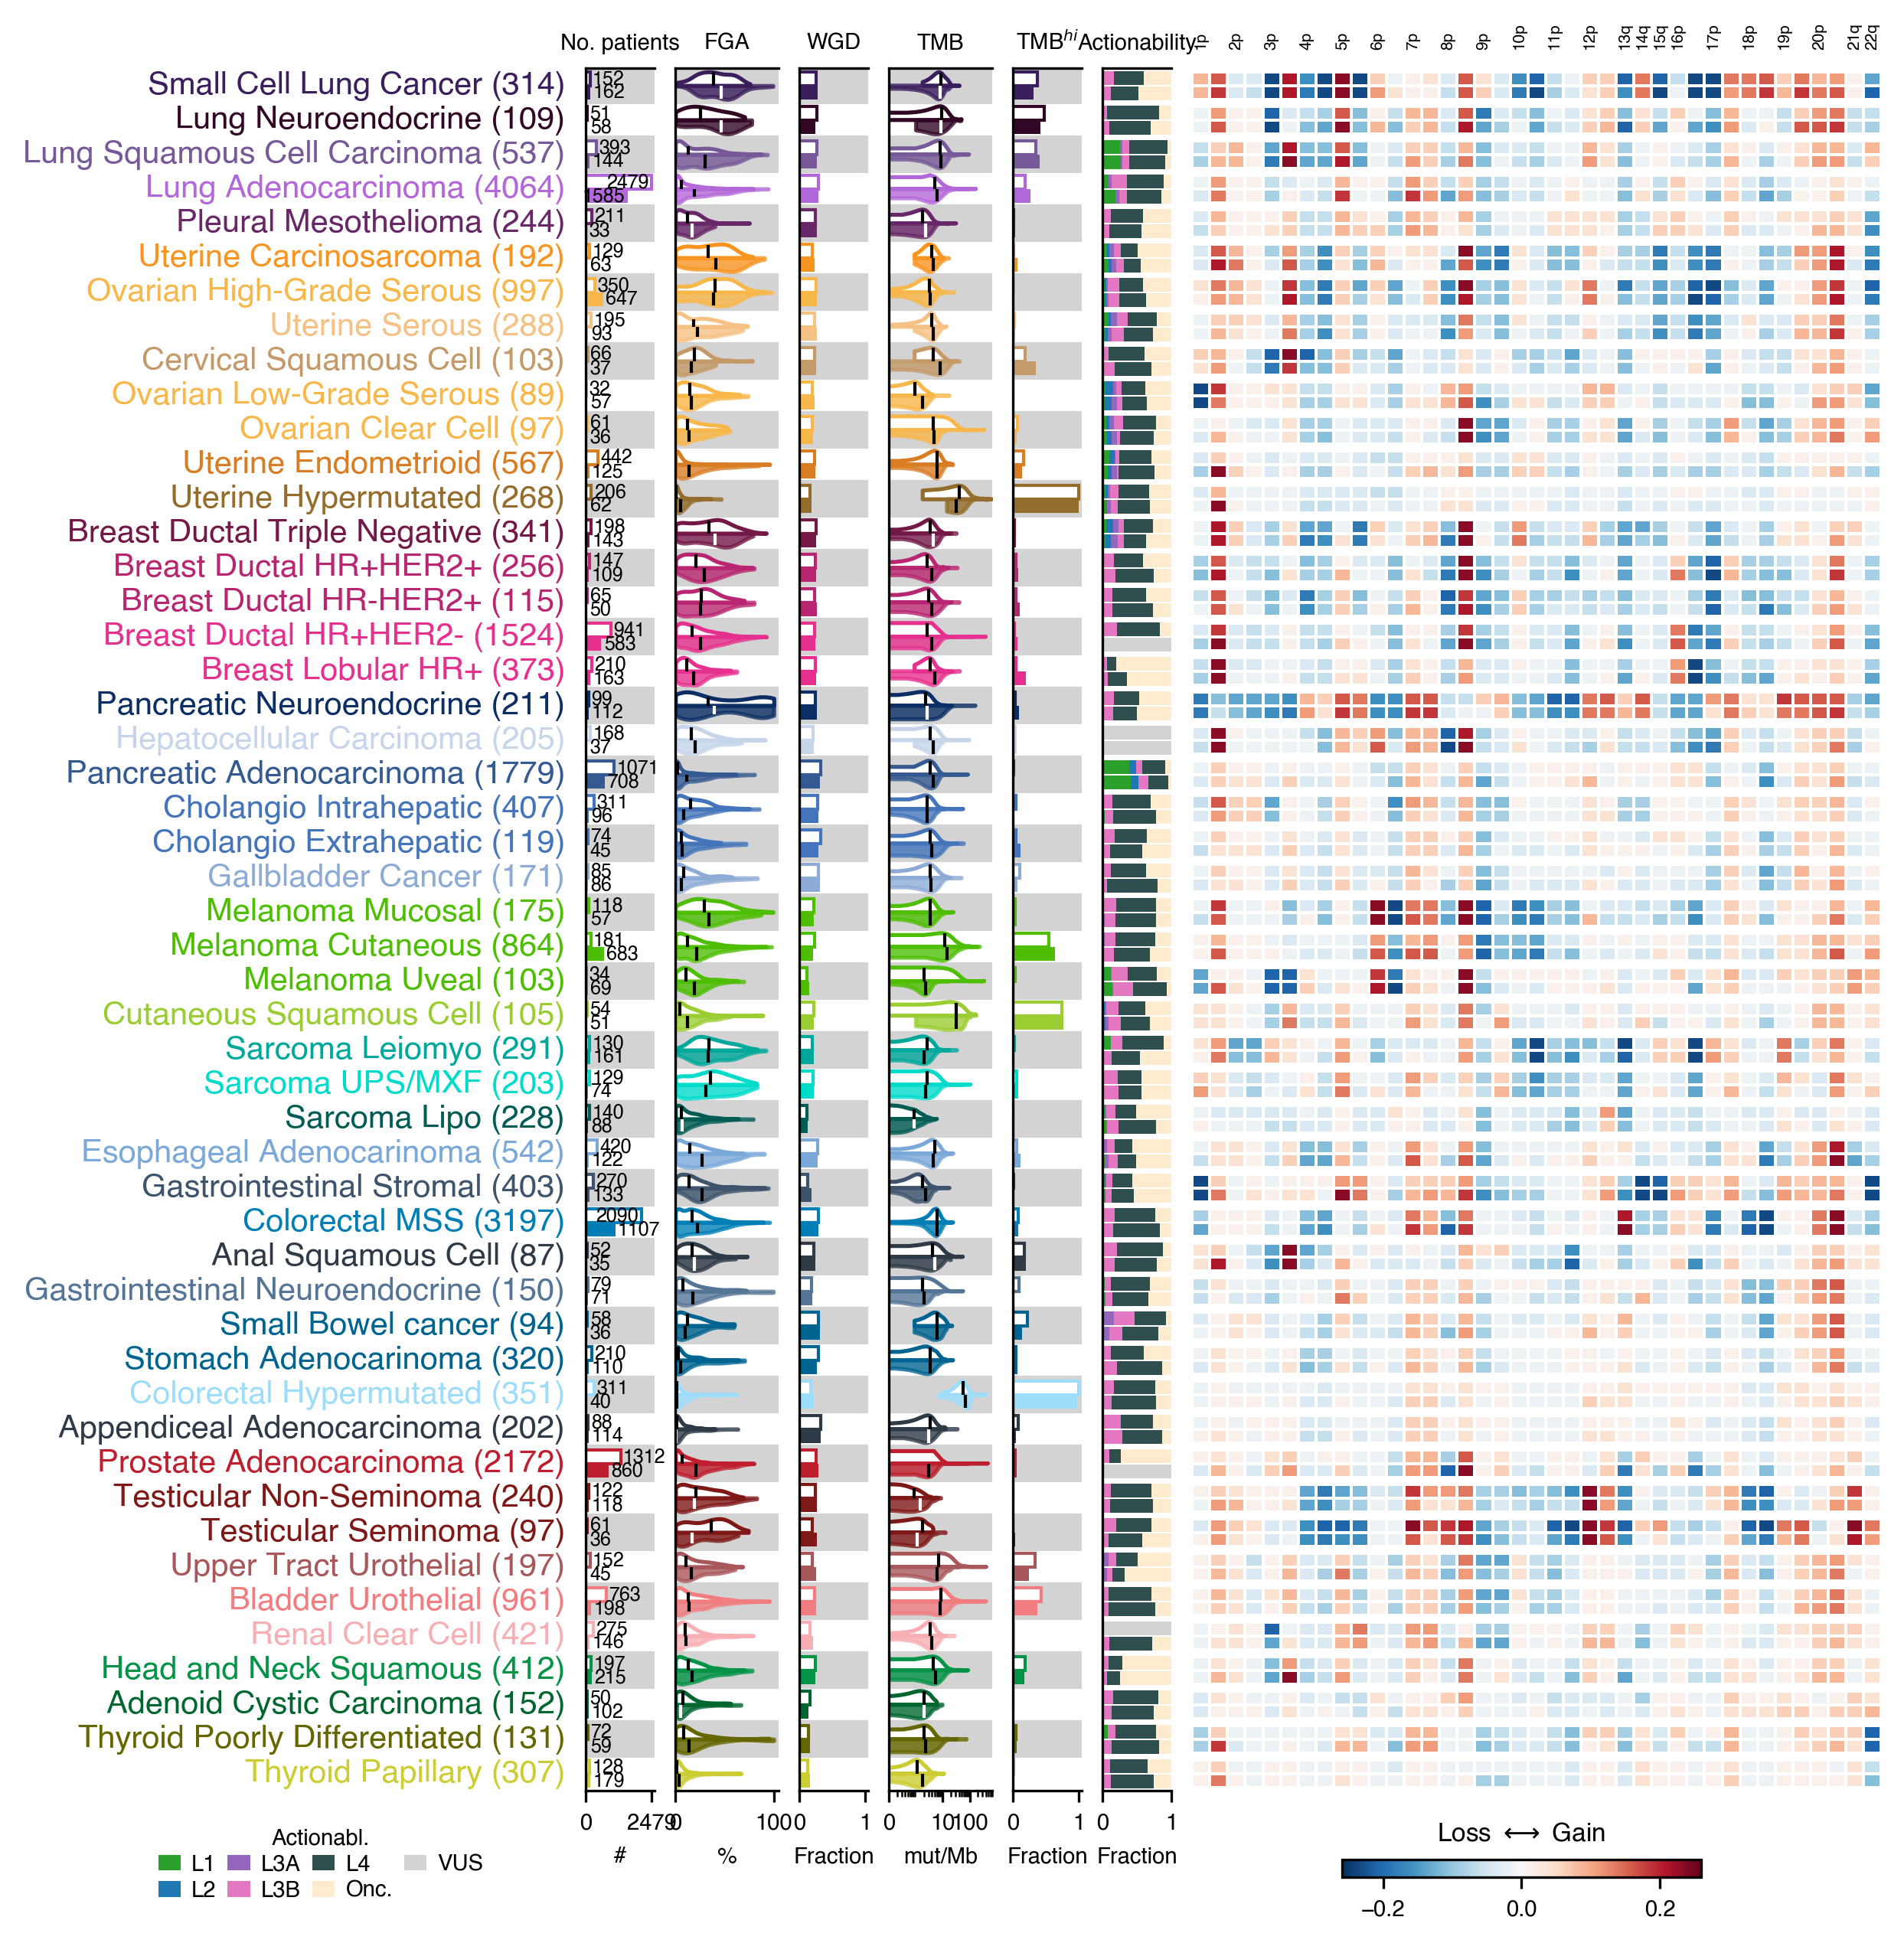

In [1057]:
w_margin = 0.3
pad_b = 0.1
pad_t = 0.1
width_ratios = np.array([7,1,1.5,1,1.5,1,1,10])
height_ratios = np.array([1]*50)

total_width = width_ratios.sum() + w_margin * (len(width_ratios) - 1)
total_height = height_ratios.sum()

xs = np.insert(np.cumsum(width_ratios[:-1]  + w_margin), 0, 0)/total_width
ys = np.insert(np.cumsum(height_ratios[:-1]), 0, 0)/total_height
ys = ys[::-1]
ws = width_ratios/total_width
hs = (1 - pad_b - pad_t)/total_height
w_margin = w_margin/total_width
pad_b = pad_b/total_height
fig = plt.figure(figsize = (total_width * 0.3, total_height * 0.15))

ax_text = fig.add_axes([xs[0], ys[-1], ws[0], 1])
ax_no_samples = fig.add_axes([xs[1], ys[-1], ws[1], 1])
ax_fga = fig.add_axes([xs[2], ys[-1], ws[2], 1])
ax_wgd = fig.add_axes([xs[3], ys[-1], ws[3], 1])
ax_tmb = fig.add_axes([xs[4], ys[-1], ws[4], 1])
ax_tmb_hi = fig.add_axes([xs[5], ys[-1], ws[5], 1])
ax_action = fig.add_axes([xs[6], ys[-1], ws[6], 1])
ax_heatmaps = [fig.add_axes([xs[7], y+pad_b, ws[7], hs]) for y in ys]

# plot everything

y_positions = np.arange(50, 0, -1)
y_lim = [0.5, 50.5]

text_plot(y_positions, y_lim, ax = ax_text)


two_bars_plot(prim_value = "primary_n", 
              meta_value = "metastasis_n", 
              annot=True, 
              y_positions = y_positions, 
              y_lim = y_lim, 
              ax = ax_no_samples, 
              xlabel = "#", 
              h=0.4,
              title = "No. patients")

two_bars_plot(prim_value = "our_primary_pc2", 
              meta_value = "our_metastasis_pc2", 
              annot = False, 
              y_positions = y_positions, 
              y_lim = y_lim, 
              ax = ax_wgd, 
              xlabel = "Fraction", 
              x_max = 1,
              h=0.4,
              title = "WGD")

two_bars_plot(prim_value = "num_hi_TMB_Primary", 
              meta_value = "num_hi_TMB_Metastasis", 
              annot = False, 
              y_positions = y_positions, 
              y_lim = y_lim, 
              ax = ax_tmb_hi, 
              xlabel = "Fraction", 
              x_max = 1,
              h=0.4,
              title = r"TMB$^{hi}$")

actionability_plot(y_positions=y_positions, 
                   y_lim = y_lim, 
                   ax=ax_action, h=0.4, p=0.04)

violin_plot(data = fga_data, 
            y_positions = y_positions, 
            y_lim = y_lim, 
            ax = ax_fga, 
            xlabel = "%", 
            x_max= 100,
            title = "FGA")

violin_plot(data = tmb_data, 
            y_positions = y_positions, 
            y_lim = y_lim, 
            ax = ax_tmb, 
            xlabel = "mut/Mb", 
            logscale=True,
            title = "TMB")

subtypes = fig2b_table.index.to_list()
for ax, st in zip(ax_heatmaps, subtypes):
    cna_heatmap_plot(st, ax)
    
# plot legends
plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.labelspacing"] = 0.25
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.title_fontsize"] = 7
plt.rcParams["legend.fontsize"] = 7
plt.rcParams["legend.loc"] = "upper left"

ax_action.legend(["L1", "L2", "L3A", "L3B", "L4", "Onc.", "VUS", "None"], 
                 title = "Actionabl.", bbox_to_anchor = (-14,-0.01), ncol = 4, columnspacing = 0.5, handletextpad = 0.5)
    
norm = plt.Normalize(vmin =-0.26, vmax =0.26)
sm = plt.cm.ScalarMappable(cmap= sns.color_palette("RdBu_r", as_cmap=True), norm=norm)
sm.set_array([])

cax = fig.add_axes([0.7, -0.05, 0.2, 0.01])
cbar = plt.colorbar(sm, cax=cax, orientation = 'horizontal')
cbar.ax.set_title(r'Loss $\longleftrightarrow$ Gain', fontsize = 8)
cbar.ax.tick_params(labelsize=7);

ax_heatmaps[0].set_xticks(np.arange(len(heatmap_top))+0.5)
ax_heatmaps[0].set_xticklabels(heatmap_top, rotation = 90, fontsize = 5)
ax_heatmaps[0].xaxis.tick_top() # x axis on top
ax_heatmaps[0].xaxis.set_label_position('top')
ax_heatmaps[0].set_yticks([])
ax_heatmaps[0].tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
ax_heatmaps[0].set_axis_on()

fig.savefig("fig2b.png", bbox_inches = "tight")